# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis.

In [20]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [21]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [22]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [23]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [24]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [25]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [26]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [27]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [28]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [29]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [30]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [31]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [32]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [33]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [34]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [35]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [36]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [37]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

data.shape

(200000, 224)

In [38]:
# save model outputs
a = open("../output/hospitalisation_prediction_sinusitis/data_sinusitis_record_cph_sinusitis.txt", "w")
a.write("")
a.writelines(['data_sinusitis_1 #with a record, #with no record: %.0f' % (data['sinusitis_date_1'].notna().sum()), ', %.0f' % (data['sinusitis_date_1'].isna().sum()),
              '\ndata_sinusitis_2 #with a record, #with no record: %.0f' % (data['sinusitis_date_2'].notna().sum()), ', %.0f' % (data['sinusitis_date_2'].isna().sum()),
              '\ndata_sinusitis_3 #with a record, #with no record: %.0f' % (data['sinusitis_date_3'].notna().sum()), ', %.0f' % (data['sinusitis_date_3'].isna().sum()),
              '\ndata_sinusitis_4 #with a record, #with no record: %.0f' % (data['sinusitis_date_4'].notna().sum()), ', %.0f' % (data['sinusitis_date_4'].isna().sum()),
              '\ndata_sinusitis_5 #with a record, #with no record: %.0f' % (data['sinusitis_date_5'].notna().sum()), ', %.0f' % (data['sinusitis_date_5'].isna().sum()),
              '\ndata_sinusitis_6 #with a record, #with no record: %.0f' % (data['sinusitis_date_6'].notna().sum()), ', %.0f' % (data['sinusitis_date_6'].isna().sum()),
              '\ndata_sinusitis_7 #with a record, #with no record: %.0f' % (data['sinusitis_date_7'].notna().sum()), ', %.0f' % (data['sinusitis_date_7'].isna().sum()),
              '\ndata_sinusitis_8 #with a record, #with no record: %.0f' % (data['sinusitis_date_8'].notna().sum()), ', %.0f' % (data['sinusitis_date_8'].isna().sum()),
              '\ndata_sinusitis_9 #with a record, #with no record: %.0f' % (data['sinusitis_date_9'].notna().sum()), ', %.0f' % (data['sinusitis_date_9'].isna().sum()),
              '\ndata_sinusitis_10 #with a record, #with no record: %.0f' % (data['sinusitis_date_10'].notna().sum()), ', %.0f' % (data['sinusitis_date_10'].isna().sum()),
              '\ndata_sinusitis_11 #with a record, #with no record: %.0f' % (data['sinusitis_date_11'].notna().sum()), ', %.0f' % (data['sinusitis_date_11'].isna().sum()),
              '\ndata_sinusitis_12 #with a record, #with no record: %.0f' % (data['sinusitis_date_12'].notna().sum()), ', %.0f' % (data['sinusitis_date_12'].isna().sum()),
              '\ndata_sinusitis_13 #with a record, #with no record: %.0f' % (data['sinusitis_date_13'].notna().sum()), ', %.0f' % (data['sinusitis_date_13'].isna().sum()),
              '\ndata_sinusitis_14 #with a record, #with no record: %.0f' % (data['sinusitis_date_14'].notna().sum()), ', %.0f' % (data['sinusitis_date_14'].isna().sum()),
              '\ndata_sinusitis_15 #with a record, #with no record: %.0f' % (data['sinusitis_date_15'].notna().sum()), ', %.0f' % (data['sinusitis_date_15'].isna().sum()),
              '\ndata_sinusitis_16 #with a record, #with no record: %.0f' % (data['sinusitis_date_16'].notna().sum()), ', %.0f' % (data['sinusitis_date_16'].isna().sum()),
              '\ndata_sinusitis_17 #with a record, #with no record: %.0f' % (data['sinusitis_date_17'].notna().sum()), ', %.0f' % (data['sinusitis_date_17'].isna().sum()),
              '\ndata_sinusitis_18 #with a record, #with no record: %.0f' % (data['sinusitis_date_18'].notna().sum()), ', %.0f' % (data['sinusitis_date_18'].isna().sum()),
              '\ndata_sinusitis_19 #with a record, #with no record: %.0f' % (data['sinusitis_date_19'].notna().sum()), ', %.0f' % (data['sinusitis_date_19'].isna().sum()),
              '\ndata_sinusitis_20 #with a record, #with no record: %.0f' % (data['sinusitis_date_20'].notna().sum()), ', %.0f' % (data['sinusitis_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [39]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37010
1.0     36862
2.0     33005
3.0     25152
4.0     14842
6.0     12350
7.0      9895
5.0      8319
8.0      8089
9.0      5758
10.0     3371
11.0     1891
12.0     1343
13.0      847
14.0      527
15.0      340
16.0      216
17.0       99
18.0       57
19.0       16
20.0        7
21.0        3
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [40]:
#read 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)
data_sinusitis.shape

(359708, 20)

### 2-2- add season, event, and duration variables
#### season

In [41]:
# convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] #gp_cons_sinusitis
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')
print(f'min date: {data_sinusitis.date.min()}')
print(f'max date: {data_sinusitis.date.max()}')
print(f'length of data_sinusitis: {len(data_sinusitis)}')

min date: 2019-01
max date: 2022-11
length of data_sinusitis: 359708


In [42]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

print(data_sinusitis['season'].value_counts())
print(f'\nmin date: {data_sinusitis.date.min()}')
print(f'max date: {data_sinusitis.date.max()}')
print(f'length: {len(data_sinusitis)}')

summer    93543
spring    92945
winter    82824
autumn    68929
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 338241


In [43]:
# data_sinusitis = data_sinusitis[data_sinusitis['date'] <= '2019-12']
# data_sinusitis = data_sinusitis[(data_sinusitis['date'] >= '2020-03') & (data_sinusitis['date']<= '2021-03')]
# data_sinusitis = data_sinusitis[data_sinusitis['date'] >= '2021-04']
# print(f'min date: {data_sinusitis.date.min()}')
# print(f'max date: {data_sinusitis.date.max()}')

In [44]:
#add period variable
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-01') & (data_sinusitis['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [45]:
#scenario 1
#not hosped (nothing happened)
#data_sinusitis = data_sinusitis[data_sinusitis['admitted_sinusitis_date'].notnull()]
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    236578
Name: event_sinusitis_admitted, dtype: int64

In [46]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days #gp_cons_sinusitis
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]
data_sinusitis['delta_sinusitis_admitted'].value_counts()

1.0       95
49.0      93
195.0     90
234.0     89
17.0      89
          ..
1393.0     1
1355.0     1
1406.0     1
1400.0     1
1390.0     1
Name: delta_sinusitis_admitted, Length: 1398, dtype: int64

In [47]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_died'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_sinusitis['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

285027

In [48]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    288114
1.0      2198
Name: event_sinusitis_admitted, dtype: int64

In [49]:
#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30
data_sinusitis['duration_sinusitis_admitted'].value_counts()

30.0    288171
1.0         95
17.0        89
15.0        88
6.0         88
4.0         84
11.0        82
18.0        81
16.0        80
14.0        77
9.0         75
13.0        74
22.0        73
8.0         73
10.0        71
19.0        70
5.0         68
24.0        68
28.0        68
12.0        67
25.0        66
21.0        66
2.0         66
26.0        65
27.0        62
20.0        60
29.0        60
0.0         58
7.0         58
3.0         58
23.0        51
Name: duration_sinusitis_admitted, dtype: int64

In [50]:
# give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    288108
1.0      2204
Name: event_sinusitis_admitted, dtype: int64

In [51]:
#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

In [52]:
# data_sinusitis[data_sinusitis['duration_sinusitis_admitted']==0][['delta_sinusitis_admitted', 'sinusitis_date', 'gp_cons_sinusitis', 'admitted_sinusitis_date', 'delta_sinusitis_admitted', 'delta_admitted_died_deregistered', 'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[151:200, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[201:250, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])
data_sinusitis[['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])

,event_sinusitis_admitted,duration_sinusitis_admitted
175863,1.0,1.0
307036,1.0,1.0
31090,1.0,1.0
298520,1.0,1.0
353601,1.0,1.0
...,...,...
120306,0.0,30.0
120303,0.0,30.0
120302,0.0,30.0
120311,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [53]:
# prep before plot
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14']
# drop anybody with age less than 18
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)]  
print(f'Min age: {data_sinusitis.age.min()}')

## remove died cases
#data_sinusitis.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
# replace 0s with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [54]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})

In [55]:
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
    # drop region value missing
    # data_sinusitis['region_imp'] = data_sinusitis['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_sinusitis.region.isnull().sum()}')
    data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

print(f'Cound of missing values in variable region: {data_sinusitis.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_sinusitis.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35433
East                        17850
East Midlands               17754
West Midlands               17747
North East                  17711
South West                  17700
Yorkshire and The Humber    17623
South East                  17428
North West                  17117
Name: region, dtype: int64


In [56]:
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)
    # data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 3
Mean of antibacterial_brit values before changing NAN to zeros: 1.248

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.248


In [57]:
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')
    # data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].astype(str)
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44178
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    105626
3.0     13593
5.0     12966
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    105626
0.0     44178
3.0     13593
5.0     12966
Name: ethnicity, dtype: int64


In [58]:
if ('smoking_status' in data_sinusitis.columns) and (data_sinusitis['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')
    # data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].astype(str)
    data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73469
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    68771
3.0    22605
2.0    11518
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73469
1.0    68771
3.0    22605
2.0    11518
Name: smoking_status, dtype: int64


In [59]:
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_sinusitis.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_sinusitis.imd.value_counts()}')
    # data_sinusitis['imd'] = data_sinusitis['imd'].astype(str)
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_sinusitis.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_sinusitis.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
3    33751
5    33478
2    33462
4    33311
1    33291
0     9070
Name: imd, dtype: int64


In [60]:
data_sinusitis['bmi_cat'] = 5
col_bmi_cat = data_sinusitis.columns.get_loc('bmi_cat')

col_sex = data_sinusitis.columns.get_loc('sex')
col_age = data_sinusitis.columns.get_loc('age')
col_bmi = data_sinusitis.columns.get_loc('bmi')

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, col_bmi] >= 30:
        data_sinusitis.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_sinusitis.iat[idx, col_bmi] >= 25) and (data_sinusitis.iat[idx, col_bmi] < 30):
        data_sinusitis.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, col_bmi] >= 18.5) and (data_sinusitis.iat[idx, col_bmi] < 25):
        data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, col_bmi] < 18.5:
        data_sinusitis.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_sinusitis['bmi_cat'].value_counts()

1    91863
5    44858
2    20160
3    14041
4     5441
Name: bmi_cat, dtype: int64

In [61]:
if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')
    # data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].astype(str)
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91863
5    44858
2    20160
3    14041
4     5441
Name: bmi_cat, dtype: int64


In [62]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])

#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)
data_sinusitis['ab_type_cat'].value_counts()

no             158969
0               13953
other            2032
Amoxicillin      1054
Doxycycline       355
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [63]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [64]:
# reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})
data_sinusitis['ab_type_cat'].value_counts()

no             158969
other           15985
Amoxicillin      1054
Doxycycline       355
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [65]:
# categorising
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_sinusitis['CCI_cat'].value_counts()

low          61270
medium       35366
very_low     32793
very_high    28680
high         18254
Name: CCI_cat, dtype: int64

In [66]:
# assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)
data_sinusitis['antibacterial_brit'].max()

data_sinusitis['antibacterial_brit_cat'] = pd.cut(data_sinusitis['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_sinusitis['antibacterial_brit_cat'].value_counts()

low       102240
high       44043
medium     30080
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

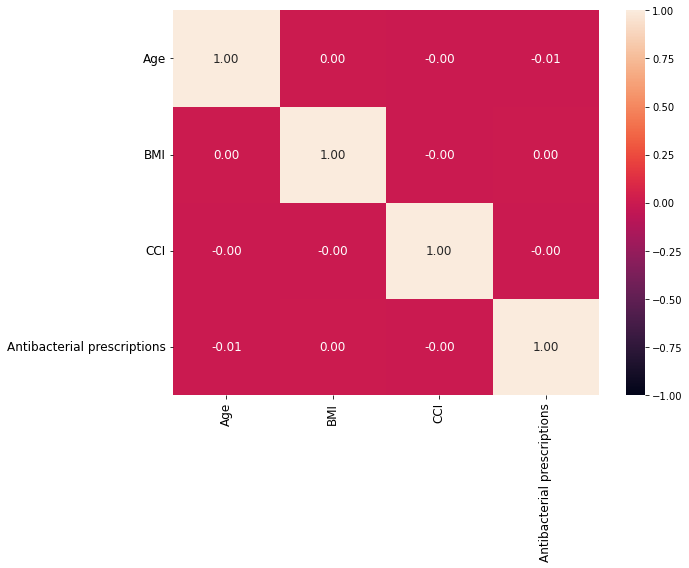

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

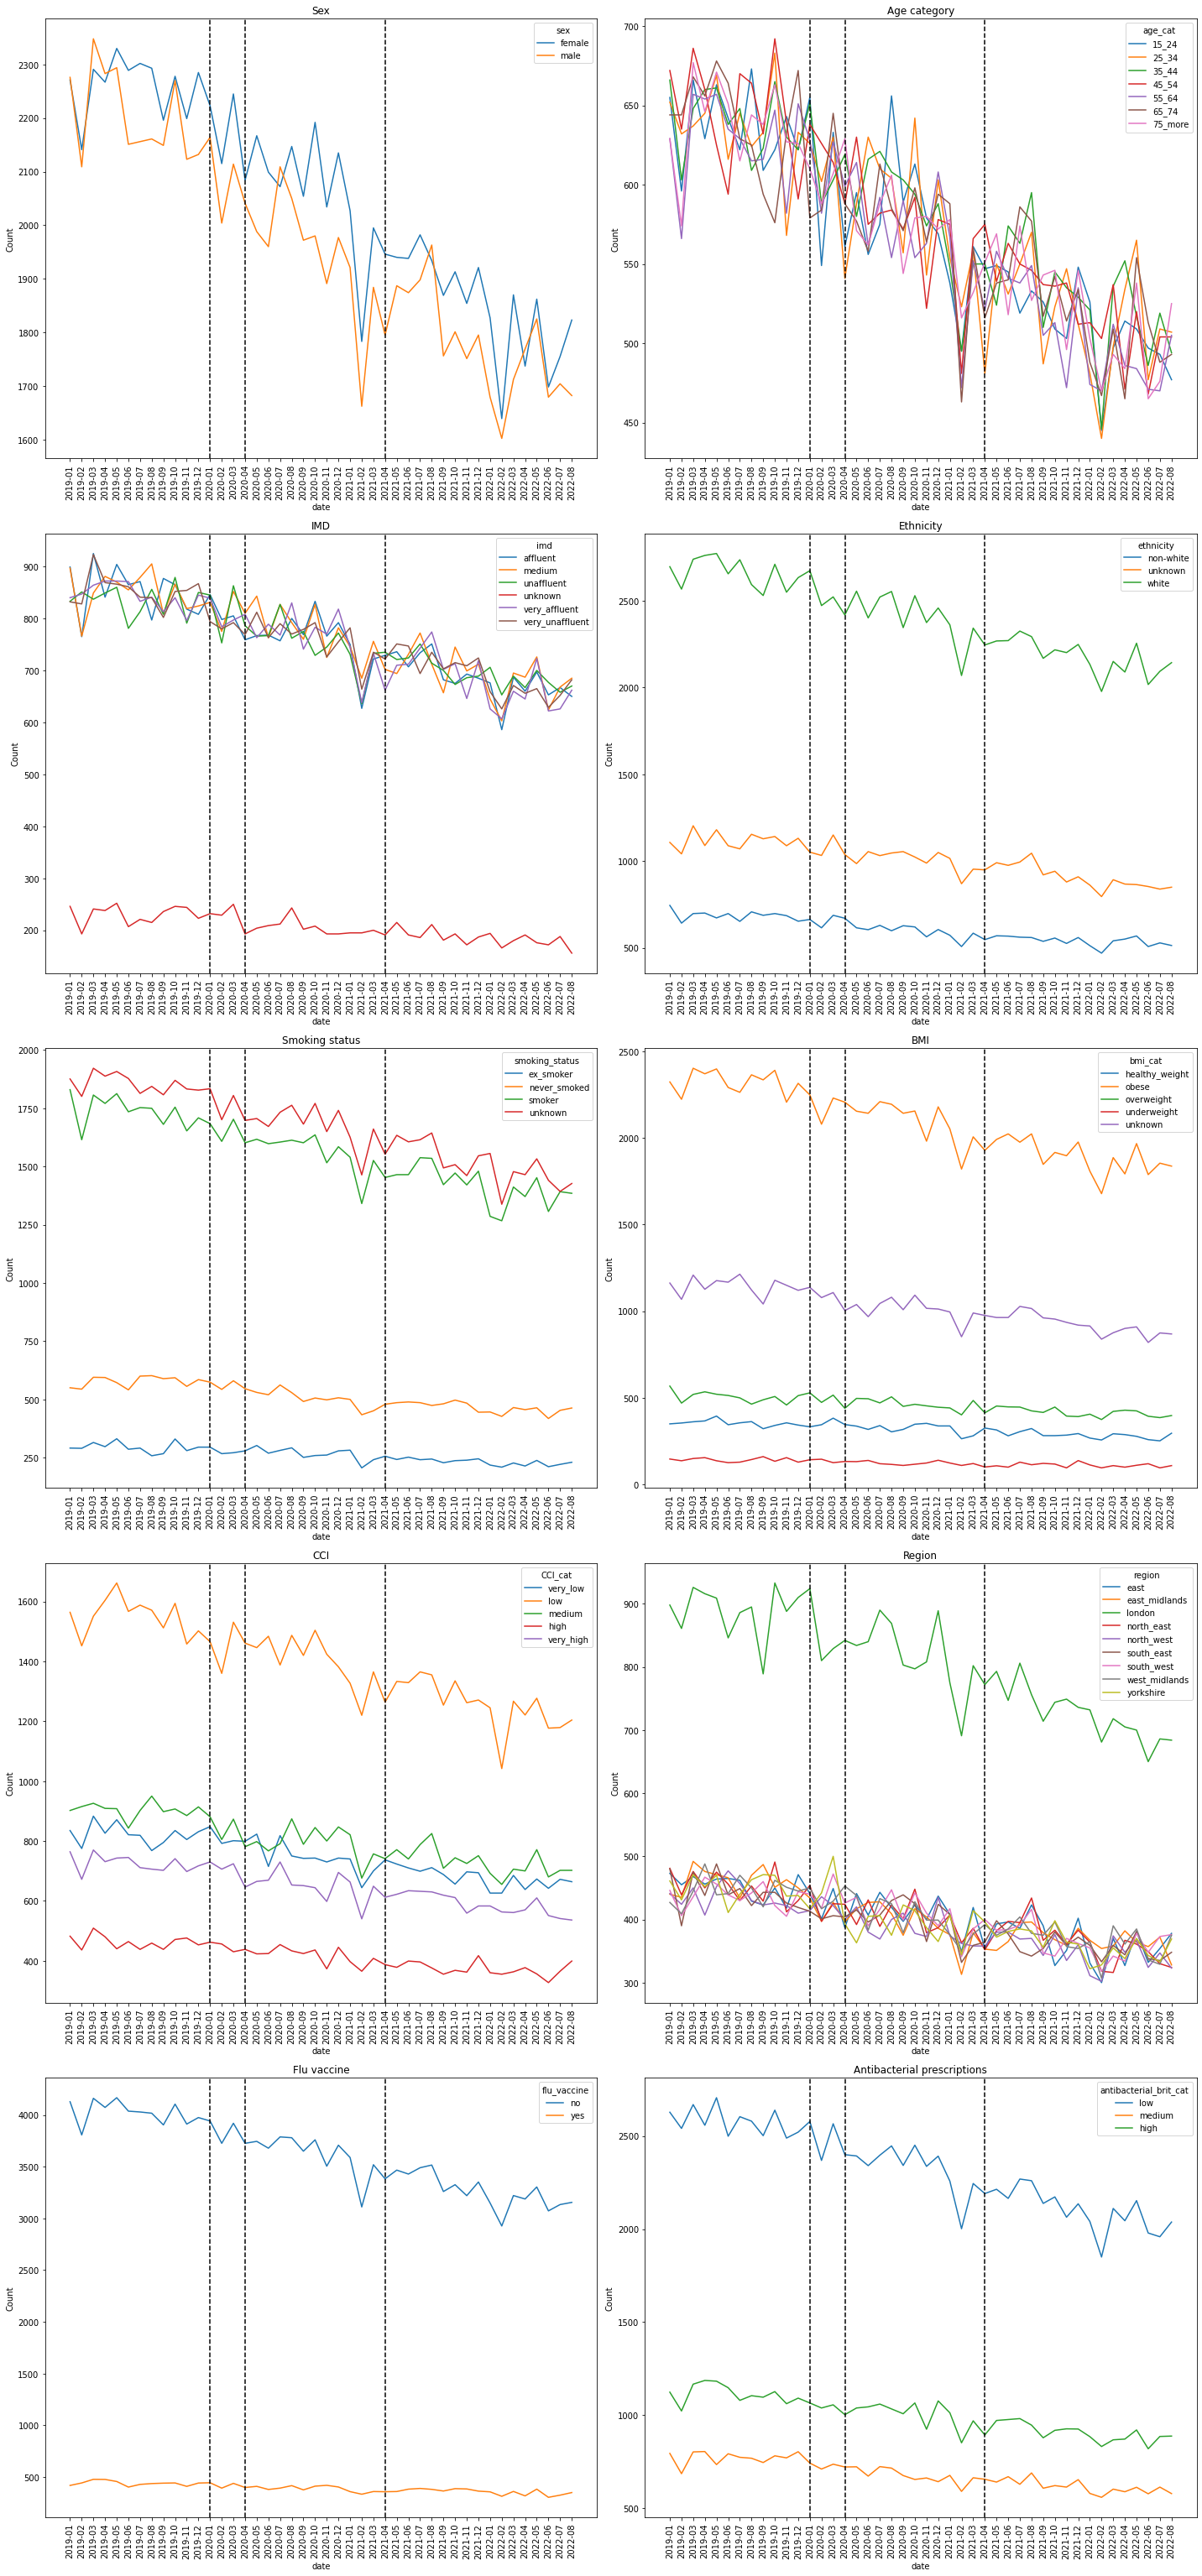

In [68]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_sinusitis, 'sex', 'Sex', axes[0,0])
create_lineplot(data_sinusitis, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_sinusitis, 'imd', 'IMD', axes[1,0])
create_lineplot(data_sinusitis, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_sinusitis, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_sinusitis, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_sinusitis, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_sinusitis, 'region', 'Region', axes[3,1])
create_lineplot(data_sinusitis, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_sinusitis, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of sinusitis patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/risk_factors_cat_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of sinusitis to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [69]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                       'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                        ]]

data_sinusitis.shape

(176363, 18)

In [70]:
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis_incdt[['sinusitis_ab_date']] = data_sinusitis_incdt[['sinusitis_ab_date']].where(data_sinusitis_incdt[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
data_sinusitis_prevl[['sinusitis_ab_date']] = data_sinusitis_prevl[['sinusitis_ab_date']].where(data_sinusitis_prevl[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_sinusitis_incdt_males = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'male']
data_sinusitis_incdt_females = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'female']
data_sinusitis_prevl_males = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'male']
data_sinusitis_prevl_females = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_sinusitis_incdt_15_24 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '15_24']
data_sinusitis_incdt_25_34 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '25_34']
data_sinusitis_incdt_35_44 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '35_44']
data_sinusitis_incdt_45_54 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '45_54']
data_sinusitis_incdt_55_64 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '55_64']
data_sinusitis_incdt_65_74 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '65_74']
data_sinusitis_incdt_75_more = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '75_more']
data_sinusitis_prevl_15_24 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '15_24']
data_sinusitis_prevl_25_34 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '25_34']
data_sinusitis_prevl_35_44 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '35_44']
data_sinusitis_prevl_45_54 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '45_54']
data_sinusitis_prevl_55_64 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '55_64']
data_sinusitis_prevl_65_74 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '65_74']
data_sinusitis_prevl_75_more = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '75_more']

data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2019-12']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['date'] >= '2020-03') & (data_sinusitis_incdt['date']<= '2021-03')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2021-04']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2019-12']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['date'] >= '2020-03') & (data_sinusitis_prevl['date']<= '2021-03')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_sinusitis_incdt_abtype_0 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[0]]
# data_sinusitis_incdt_abtype_1 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[1]]
# data_sinusitis_incdt_abtype_2 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[2]]
# data_sinusitis_incdt_abtype_3 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[3]]
# data_sinusitis_prevl_abtype_0 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[0]]
# data_sinusitis_prevl_abtype_1 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[1]]
# data_sinusitis_prevl_abtype_2 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[2]]
# data_sinusitis_prevl_abtype_3 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_sinusitis_incdt_abs = data_sinusitis_incdt[data_sinusitis_incdt['sinusitis_ab_date'] == 1]
# data_sinusitis_prevl_abs = data_sinusitis_prevl[data_sinusitis_prevl['sinusitis_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()] #gp_cons_sinusitis_ab
data_sinusitis_no_abs_incdt = data_sinusitis_no_abs_incdt[data_sinusitis_no_abs_incdt['incdt_sinusitis_date'] == 0]

# with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_incdt = data_sinusitis_abs_incdt[data_sinusitis_abs_incdt['incdt_sinusitis_date'] == 0]

# no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_prevl = data_sinusitis_no_abs_prevl[data_sinusitis_no_abs_prevl['incdt_sinusitis_date'] == 1]

# with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_prevl = data_sinusitis_abs_prevl[data_sinusitis_abs_prevl['incdt_sinusitis_date'] == 1]

print(f'shape of data_sinusitis_incdt: {data_sinusitis_incdt.shape}')
print(f'shape of data_sinusitis_prevl: {data_sinusitis_prevl.shape}')
print(f'shape of data_sinusitis_no_abs_incdt: {data_sinusitis_no_abs_incdt.shape}')
print(f'shape of data_sinusitis_abs_incdt: {data_sinusitis_abs_incdt.shape}')
print(f'shape of data_sinusitis_no_abs_prevl: {data_sinusitis_no_abs_prevl.shape}')
print(f'shape of data_sinusitis_abs_prevl: {data_sinusitis_abs_prevl.shape}')
print(f'\nvalue counts of data_sinusitis_no_abs_incdt: \n{data_sinusitis_no_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_abs_incdt: \n{data_sinusitis_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_no_abs_prevl: \n{data_sinusitis_no_abs_prevl.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_abs_prevl: \n{data_sinusitis_abs_prevl.event_sinusitis_admitted.value_counts()}')

shape of data_sinusitis_incdt: (158844, 18)
shape of data_sinusitis_prevl: (17519, 18)
shape of data_sinusitis_no_abs_incdt: (143159, 18)
shape of data_sinusitis_abs_incdt: (15685, 18)
shape of data_sinusitis_no_abs_prevl: (15810, 18)
shape of data_sinusitis_abs_prevl: (1709, 18)

value counts of data_sinusitis_no_abs_incdt: 
0.0    142061
1.0      1098
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_abs_incdt: 
0.0    15570
1.0      115
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_no_abs_prevl: 
0.0    15700
1.0      110
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_abs_prevl: 
0.0    1693
1.0      16
Name: event_sinusitis_admitted, dtype: int64


In [71]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 107369 total observations, 106575 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 107369
number of events observed = 794
   partial log-likelihood = -9181.08
         time fit was run = 2022-11-24 01:09:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.10            -0.38             0.01                 0.68                 1.01
CCI_cat[T.medium]               -0.09       0.91       0.11            -0.31             0.13                 0.74                 1.13
CCI_cat[T.high]                 -0.11       0.89       0.13            -0.38             0.15                 0.69                 1.16
CCI_cat[T.very_high]            -0.19       0.83       0.12            -0.42             0.04                 0.65                 1.05
age_cat[T.25_34]                -0.14       0.87       0.14            -0.40             0.13                 0.67                 1.13
age_cat[T.35_44]                 0.00       1.00       0.13            -0.25             0.26                 0.78                 1.29
age_cat[T.45_54]                -0.18       0.84       0.14            -0.45             0.09                 0.64                 1.09
age_cat[T.55_64]                 0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
age_cat[T.65_74]                -0.09       0.91       0.13            -0.35             0.17                 0.70                 1.19
age_cat[T.75_more]               0.02       1.02       0.13            -0.23             0.28                 0.79                 1.32
antibacterial_brit              -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
bmi_cat[T.obese]                 0.10       1.11       0.14            -0.18             0.38                 0.84                 1.46
bmi_cat[T.overweight]            0.07       1.08       0.17            -0.26             0.41                 0.77                 1.50
bmi_cat[T.underweight]           0.24       1.27       0.23            -0.21             0.69                 0.81                 2.00
bmi_cat[T.unknown]               0.13       1.14       0.15            -0.16             0.43                 0.85                 1.53
ethnicity[T.unknown]             0.05       1.06       0.11            -0.17             0.28                 0.84                 1.32
ethnicity[T.white]              -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
flu_vaccine[T.yes]               0.02       1.02       0.12            -0.21             0.25                 0.81                 1.29
imd[T.medium]                   -0.11       0.89       0.12            -0.34             0.12                 0.71                 1.13
imd[T.unaffluent]                0.02       1.02       0.11            -0.20             0.25                 0.82                 1.28
imd[T.unknown]                   0.08       1.08       0.17            -0.25             0.41                 0.78                 1.51
imd[T.very_affluent]            -0.03       0.97       0.12            -0.26             0.19                 0.77                 1.21
imd[T.very_unaffluent]           0.06       1.06       0.11            -0.17             0.28                 0.85                 1.32
region[T.east_midlands]          0.17       1.18       0.16            -0.14             0.47                 0.87                 1.60
region[T.london]                 0.04       1.04       

12776


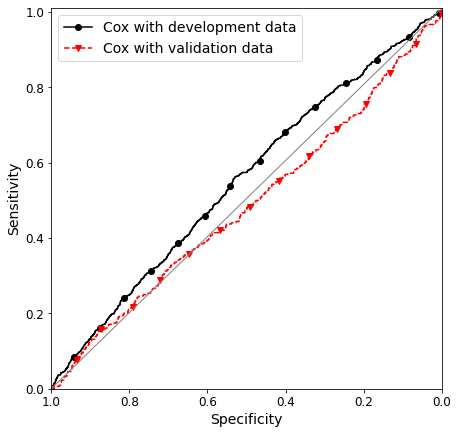

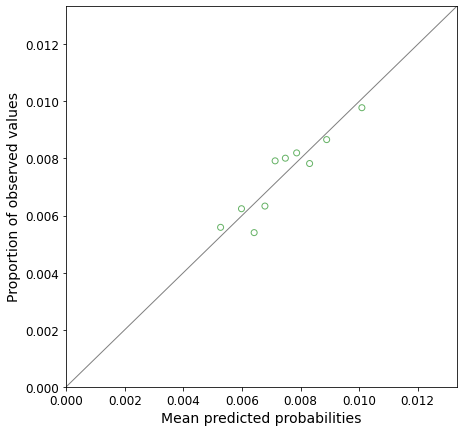

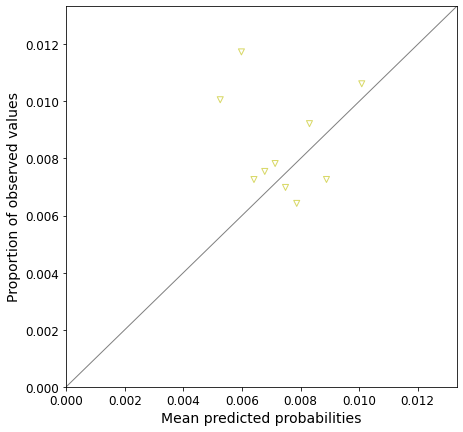

In [72]:
#data prep
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test = cox_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_no_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_incdt.csv', data_sinusitis_no_abs_incdt_enc, data_sinusitis_no_abs_incdt, 'sum_betas_cph_sinusitis_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_no_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_incdt_train.jpg', 'calibration_cph_sinusitis_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 11763 total observations, 11678 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 11763
number of events observed = 85
   partial log-likelihood = -780.27
         time fit was run = 2022-11-24 01:09:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.31            -0.74             0.48                 0.48                 1.62
CCI_cat[T.medium]                0.11       1.12       0.33            -0.54             0.76                 0.58                 2.14
CCI_cat[T.high]                  0.31       1.36       0.37            -0.42             1.03                 0.66                 2.80
CCI_cat[T.very_high]            -0.61       0.54       0.43            -1.46             0.23                 0.23                 1.26
age_cat[T.25_34]                 0.32       1.38       0.39            -0.44             1.09                 0.64                 2.99
age_cat[T.35_44]                -0.28       0.76       0.45            -1.16             0.61                 0.31                 1.83
age_cat[T.45_54]                 0.30       1.35       0.39            -0.47             1.07                 0.63                 2.92
age_cat[T.55_64]                 0.07       1.08       0.41            -0.73             0.88                 0.48                 2.41
age_cat[T.65_74]                 0.24       1.27       0.40            -0.55             1.03                 0.57                 2.79
age_cat[T.75_more]              -0.65       0.52       0.51            -1.64             0.35                 0.19                 1.42
antibacterial_brit               0.03       1.03       0.08            -0.12             0.18                 0.89                 1.20
bmi_cat[T.obese]                 0.70       2.01       0.52            -0.32             1.72                 0.73                 5.56
bmi_cat[T.overweight]            0.57       1.78       0.59            -0.59             1.74                 0.56                 5.67
bmi_cat[T.underweight]           0.77       2.15       0.77            -0.73             2.27                 0.48                 9.65
bmi_cat[T.unknown]               0.24       1.27       0.56            -0.86             1.33                 0.42                 3.80
ethnicity[T.unknown]             0.10       1.10       0.35            -0.59             0.78                 0.56                 2.18
ethnicity[T.white]              -0.07       0.94       0.31            -0.68             0.55                 0.51                 1.73
flu_vaccine[T.yes]              -0.20       0.82       0.40            -0.98             0.57                 0.38                 1.78
imd[T.medium]                    0.25       1.29       0.32            -0.37             0.88                 0.69                 2.41
imd[T.unaffluent]               -0.59       0.56       0.41            -1.39             0.21                 0.25                 1.24
imd[T.unknown]                  -0.08       0.92       0.55            -1.17             1.00                 0.31                 2.72
imd[T.very_affluent]             0.04       1.04       0.33            -0.62             0.69                 0.54                 2.00
imd[T.very_unaffluent]          -0.22       0.80       0.36            -0.92             0.48                 0.40                 1.62
region[T.east_midlands]          0.47       1.59       0.52            -0.55             1.48                 0.58                 4.39
region[T.london]                -0.05       0.95       0.50 

12774


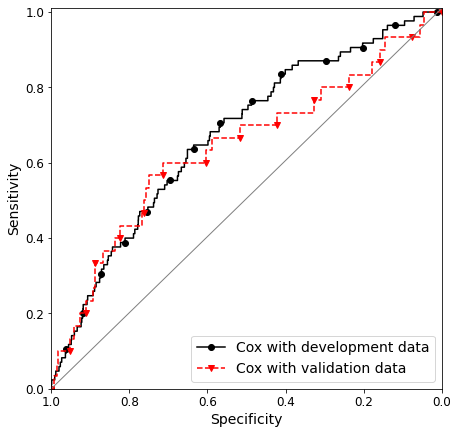

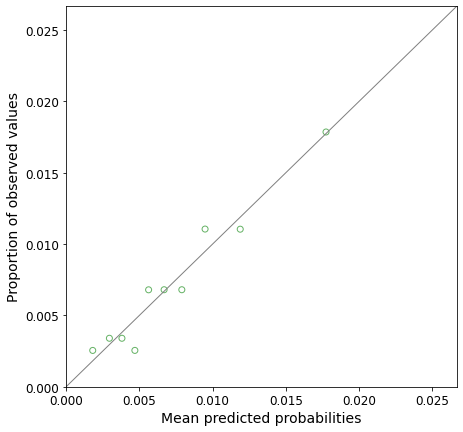

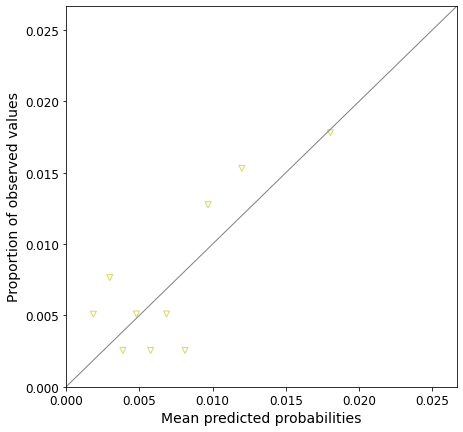

In [73]:
#data prep
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test = cox_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_incdt.csv', data_sinusitis_abs_incdt_enc, data_sinusitis_abs_incdt, 'sum_betas_cph_sinusitis_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_incdt_train.jpg', 'calibration_cph_sinusitis_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 11857 total observations, 11768 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 11857
number of events observed = 89
   partial log-likelihood = -818.55
         time fit was run = 2022-11-24 01:09:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.31            -0.80             0.42                 0.45                 1.52
CCI_cat[T.medium]                0.07       1.07       0.33            -0.58             0.71                 0.56                 2.04
CCI_cat[T.high]                 -0.08       0.92       0.41            -0.89             0.73                 0.41                 2.07
CCI_cat[T.very_high]             0.03       1.03       0.35            -0.65             0.71                 0.52                 2.04
age_cat[T.25_34]                 0.04       1.04       0.42            -0.78             0.86                 0.46                 2.36
age_cat[T.35_44]                 0.25       1.28       0.40            -0.54             1.04                 0.58                 2.83
age_cat[T.45_54]                -0.29       0.75       0.45            -1.17             0.60                 0.31                 1.81
age_cat[T.55_64]                 0.39       1.47       0.39            -0.38             1.16                 0.68                 3.18
age_cat[T.65_74]                 0.44       1.56       0.38            -0.31             1.20                 0.74                 3.31
age_cat[T.75_more]              -0.24       0.79       0.45            -1.12             0.64                 0.33                 1.90
antibacterial_brit               0.01       1.01       0.07            -0.14             0.15                 0.87                 1.16
bmi_cat[T.obese]                 0.52       1.68       0.47            -0.40             1.44                 0.67                 4.21
bmi_cat[T.overweight]            0.53       1.71       0.53            -0.51             1.58                 0.60                 4.86
bmi_cat[T.underweight]          -0.72       0.49       1.10            -2.87             1.43                 0.06                 4.17
bmi_cat[T.unknown]               0.10       1.10       0.51            -0.90             1.09                 0.41                 2.99
ethnicity[T.unknown]            -0.22       0.80       0.33            -0.87             0.43                 0.42                 1.54
ethnicity[T.white]              -0.16       0.85       0.29            -0.72             0.40                 0.48                 1.49
flu_vaccine[T.yes]              -0.13       0.87       0.37            -0.86             0.59                 0.42                 1.81
imd[T.medium]                   -0.28       0.76       0.35            -0.96             0.40                 0.38                 1.49
imd[T.unaffluent]                0.08       1.08       0.32            -0.55             0.71                 0.58                 2.03
imd[T.unknown]                  -0.26       0.77       0.55            -1.34             0.82                 0.26                 2.27
imd[T.very_affluent]            -0.12       0.88       0.33            -0.78             0.53                 0.46                 1.70
imd[T.very_unaffluent]          -0.32       0.73       0.35            -1.01             0.37                 0.36                 1.45
region[T.east_midlands]          0.10       1.10       0.49            -0.86             1.05                 0.43                 2.86
region[T.london]                 0.39       1.47       0.41 

12782


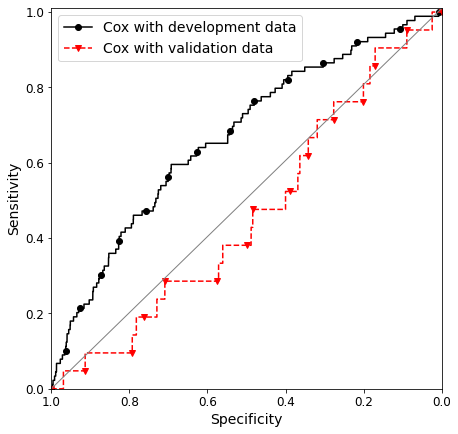

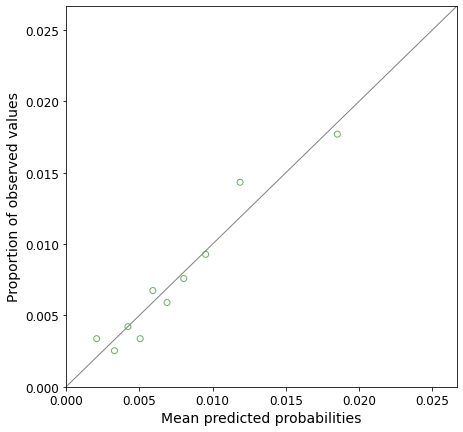

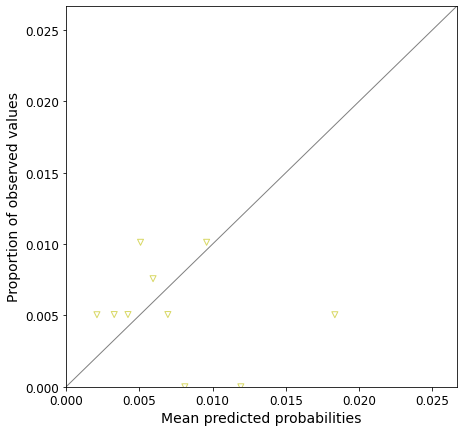

In [74]:
#data prep
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test = cox_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_no_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_prevl.csv', data_sinusitis_no_abs_prevl_enc, data_sinusitis_no_abs_prevl, 'sum_betas_cph_sinusitis_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_no_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_prevl_train.jpg', 'calibration_cph_sinusitis_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 1281 total observations, 1266 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1281
number of events observed = 15
   partial log-likelihood = -83.90
         time fit was run = 2022-11-24 01:09:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.76            -1.27             1.72                 0.28                 5.60
CCI_cat[T.medium]               -0.22       0.80       0.97            -2.12             1.68                 0.12                 5.37
CCI_cat[T.high]                  0.79       2.19       0.83            -0.84             2.41                 0.43                11.10
CCI_cat[T.very_high]           -18.15       0.00    5510.53        -10818.58         10782.29                 0.00                  inf
age_cat[T.25_34]               -18.66       0.00    5683.52        -11158.15         11120.84                 0.00                  inf
age_cat[T.35_44]                -0.80       0.45       0.93            -2.61             1.02                 0.07                 2.77
age_cat[T.45_54]                -0.99       0.37       0.95            -2.85             0.87                 0.06                 2.39
age_cat[T.55_64]                -0.48       0.62       0.88            -2.21             1.25                 0.11                 3.49
age_cat[T.65_74]                -0.52       0.59       0.92            -2.33             1.29                 0.10                 3.64
age_cat[T.75_more]              -0.44       0.64       0.94            -2.29             1.41                 0.10                 4.08
antibacterial_brit              -0.13       0.88       0.21            -0.54             0.28                 0.58                 1.32
bmi_cat[T.obese]                 0.35       1.42       1.13            -1.86             2.56                 0.16                12.95
bmi_cat[T.overweight]            0.61       1.84       1.28            -1.90             3.12                 0.15                22.63
bmi_cat[T.underweight]         -17.82       0.00   11379.51        -22321.26         22285.62                 0.00                  inf
bmi_cat[T.unknown]               0.53       1.70       1.20            -1.83             2.88                 0.16                17.86
ethnicity[T.unknown]             1.28       3.61       1.14            -0.95             3.52                 0.38                33.86
ethnicity[T.white]               0.65       1.91       1.07            -1.45             2.75                 0.23                15.65
flu_vaccine[T.yes]               1.09       2.97       0.67            -0.22             2.40                 0.80                10.98
imd[T.medium]                   -0.15       0.86       0.83            -1.77             1.47                 0.17                 4.35
imd[T.unaffluent]                0.12       1.13       0.77            -1.40             1.64                 0.25                 5.16
imd[T.unknown]                 -18.15       0.00    9140.80        -17933.79         17897.49                 0.00                  inf
imd[T.very_affluent]            -1.39       0.25       1.17            -3.68             0.91                 0.03                 2.49
imd[T.very_unaffluent]          -0.47       0.62       0.83            -2.09             1.15                 0.12                 3.15
region[T.east_midlands]         -0.20       0.82       0.96            -2.08             1.69                 0.12                 5.43
region[T.london]                -0.09       0.91       0.83     

12901


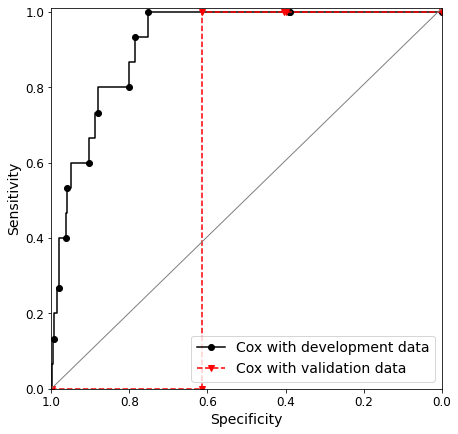

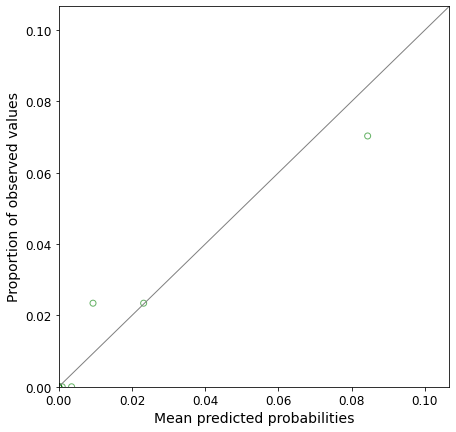

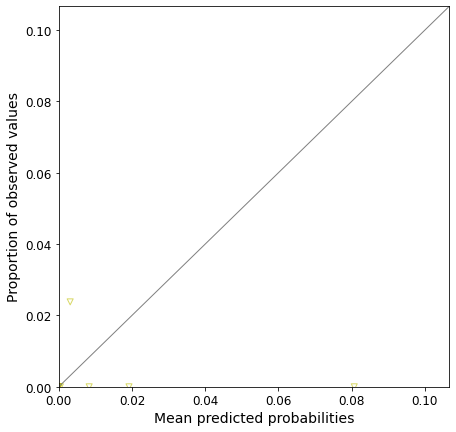

In [75]:
#data prep
data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test = cox_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_prevl.csv', data_sinusitis_abs_prevl_enc, data_sinusitis_abs_prevl, 'sum_betas_cph_sinusitis_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_prevl_train.jpg', 'calibration_cph_sinusitis_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident sinusitis

In [76]:
#data prep
data, data_sinusitis_incdt_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'incdt', data_sinusitis_incdt_enc)
make_summary_table_hosped('sinusitis', 'incdt', data_sinusitis_incdt)

try:
    cph_sinusitis_incdt, data_sinusitis_incdt_train, data_sinusitis_incdt_test = cox_model_abs_build('sinusitis', 'incdt', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt, 'sinusitis', 'incdt', data_sinusitis_incdt_train, data_sinusitis_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119133 total observations, 118213 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 119133
number of events observed = 920
   partial log-likelihood = -10732.95
         time fit was run = 2022-11-24 01:09:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.09            -0.41            -0.05                 0.66                 0.95
CCI_cat[T.medium]               -0.08       0.92       0.10            -0.28             0.12                 0.76                 1.13
CCI_cat[T.high]                 -0.10       0.90       0.12            -0.34             0.14                 0.71                 1.15
CCI_cat[T.very_high]            -0.23       0.79       0.11            -0.45            -0.01                 0.64                 0.99
age_cat[T.25_34]                -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.25
age_cat[T.35_44]                -0.11       0.90       0.12            -0.35             0.14                 0.70                 1.15
age_cat[T.45_54]                 0.01       1.01       0.12            -0.23             0.25                 0.80                 1.28
age_cat[T.55_64]                 0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
age_cat[T.65_74]                -0.00       1.00       0.12            -0.24             0.24                 0.78                 1.27
age_cat[T.75_more]              -0.07       0.93       0.12            -0.32             0.17                 0.73                 1.18
antibacterial_brit               0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.16       1.17       0.13            -0.10             0.42                 0.90                 1.53
bmi_cat[T.overweight]            0.19       1.20       0.16            -0.12             0.50                 0.88                 1.64
bmi_cat[T.underweight]           0.44       1.56       0.21             0.04             0.85                 1.04                 2.33
bmi_cat[T.unknown]               0.11       1.12       0.14            -0.17             0.39                 0.85                 1.48
ethnicity[T.unknown]            -0.03       0.97       0.11            -0.23             0.18                 0.79                 1.20
ethnicity[T.white]              -0.05       0.95       0.09            -0.23             0.13                 0.79                 1.14
flu_vaccine[T.yes]               0.04       1.04       0.11            -0.18             0.25                 0.84                 1.28
imd[T.medium]                   -0.03       0.97       0.11            -0.24             0.18                 0.79                 1.19
imd[T.unaffluent]               -0.07       0.93       0.11            -0.28             0.14                 0.75                 1.15
imd[T.unknown]                   0.00       1.00       0.16            -0.31             0.32                 0.73                 1.37
imd[T.very_affluent]            -0.04       0.96       0.11            -0.25             0.17                 0.78                 1.18
imd[T.very_unaffluent]          -0.02       0.98       0.11            -0.23             0.19                 0.79                 1.20
region[T.east_midlands]          0.24       1.27       0.14            -0.04             0.51                 0.96                 1.67
region[T.london]                -0.07       0.94      

13063


### 5-6- hospital admission related to prevalent sinusitis

In [77]:
#data prep
data, data_sinusitis_prevl_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'prevl', data_sinusitis_prevl_enc)
make_summary_table_hosped('sinusitis', 'prevl', data_sinusitis_prevl)

try:
    cph_sinusitis_prevl, data_sinusitis_prevl_train, data_sinusitis_prevl_test = cox_model_abs_build('sinusitis', 'prevl', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl, 'sinusitis', 'prevl', data_sinusitis_prevl_train, data_sinusitis_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13139 total observations, 13044 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13139
number of events observed = 95
   partial log-likelihood = -879.94
         time fit was run = 2022-11-24 01:09:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.30            -0.50             0.67                 0.61                 1.96
CCI_cat[T.medium]                0.01       1.01       0.34            -0.66             0.67                 0.52                 1.96
CCI_cat[T.high]                  0.20       1.22       0.39            -0.56             0.96                 0.57                 2.60
CCI_cat[T.very_high]             0.12       1.12       0.35            -0.57             0.80                 0.57                 2.23
age_cat[T.25_34]                -0.26       0.77       0.47            -1.19             0.67                 0.31                 1.96
age_cat[T.35_44]                 0.46       1.59       0.40            -0.33             1.25                 0.72                 3.50
age_cat[T.45_54]                 0.28       1.33       0.41            -0.53             1.10                 0.59                 2.99
age_cat[T.55_64]                 0.76       2.13       0.38             0.00             1.51                 1.00                 4.53
age_cat[T.65_74]                 0.24       1.27       0.42            -0.59             1.06                 0.56                 2.90
age_cat[T.75_more]               0.24       1.27       0.42            -0.59             1.06                 0.55                 2.89
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 0.81       2.25       0.52            -0.21             1.83                 0.81                 6.20
bmi_cat[T.overweight]            0.64       1.90       0.59            -0.51             1.79                 0.60                 5.96
bmi_cat[T.underweight]           0.61       1.83       0.77            -0.89             2.11                 0.41                 8.22
bmi_cat[T.unknown]               0.47       1.60       0.55            -0.60             1.55                 0.55                 4.69
ethnicity[T.unknown]            -0.15       0.86       0.32            -0.77             0.46                 0.46                 1.59
ethnicity[T.white]              -0.24       0.79       0.28            -0.78             0.31                 0.46                 1.37
flu_vaccine[T.yes]               0.17       1.18       0.32            -0.46             0.80                 0.63                 2.22
imd[T.medium]                   -0.16       0.85       0.33            -0.81             0.49                 0.45                 1.63
imd[T.unaffluent]                0.13       1.14       0.31            -0.48             0.74                 0.62                 2.09
imd[T.unknown]                  -1.01       0.36       0.74            -2.47             0.44                 0.08                 1.56
imd[T.very_affluent]            -0.24       0.79       0.34            -0.90             0.42                 0.41                 1.52
imd[T.very_unaffluent]          -0.10       0.90       0.33            -0.74             0.54                 0.48                 1.71
region[T.east_midlands]         -0.58       0.56       0.47            -1.50             0.34                 0.22                 1.40
region[T.london]                -0.11       0.90       0.35 

13051


### 5-7- hospital admission related to incident sinusitis with prescribed antibiotics categories

In [78]:
#data prep
data, data_sinusitis_incdt_abs_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_abs, data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test = cox_model_ab_type_build('sinusitis', 'incdt_ab_type', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_abs, 'sinusitis', 'incdt_abs', data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119133 total observations, 118213 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 119133
number of events observed = 920
   partial log-likelihood = -10731.45
         time fit was run = 2022-11-24 01:09:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.09            -0.41            -0.05                 0.66                 0.95
CCI_cat[T.medium]               -0.08       0.92       0.10            -0.28             0.12                 0.76                 1.13
CCI_cat[T.high]                 -0.10       0.90       0.12            -0.34             0.14                 0.71                 1.15
CCI_cat[T.very_high]            -0.23       0.79       0.11            -0.45            -0.01                 0.64                 0.99
ab_type_cat[T.Doxycycline]       1.07       2.90       1.00            -0.89             3.03                 0.41                20.62
ab_type_cat[T.no]                1.00       2.73       0.71            -0.38             2.39                 0.68                10.94
ab_type_cat[T.other]             1.04       2.82       0.72            -0.36             2.44                 0.69                11.47
age_cat[T.25_34]                -0.01       0.99       0.12            -0.25             0.23                 0.78                 1.25
age_cat[T.35_44]                -0.11       0.90       0.12            -0.35             0.14                 0.70                 1.15
age_cat[T.45_54]                 0.01       1.01       0.12            -0.22             0.25                 0.80                 1.29
age_cat[T.55_64]                 0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
age_cat[T.65_74]                -0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
age_cat[T.75_more]              -0.07       0.93       0.12            -0.32             0.17                 0.73                 1.19
antibacterial_brit               0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
bmi_cat[T.obese]                 0.16       1.17       0.13            -0.10             0.42                 0.90                 1.53
bmi_cat[T.overweight]            0.19       1.20       0.16            -0.12             0.50                 0.88                 1.64
bmi_cat[T.underweight]           0.44       1.56       0.21             0.04             0.85                 1.04                 2.33
bmi_cat[T.unknown]               0.11       1.12       0.14            -0.17             0.39                 0.85                 1.48
ethnicity[T.unknown]            -0.03       0.97       0.11            -0.23             0.18                 0.79                 1.20
ethnicity[T.white]              -0.05       0.95       0.09            -0.23             0.13                 0.79                 1.14
flu_vaccine[T.yes]               0.04       1.04       0.11            -0.18             0.25                 0.84                 1.28
imd[T.medium]                   -0.03       0.97       0.11            -0.24             0.18                 0.79                 1.19
imd[T.unaffluent]               -0.07       0.93       0.11            -0.28             0.14                 0.75                 1.15
imd[T.unknown]                   0.00       1.00       0.16            -0.31             0.32                 0.73                 1.38
imd[T.very_affluent]            -0.04       0.96      

13622


### 5-8- hospital admission related to prevalent sinusitis with prescribed antibiotics categories

In [79]:
#data prep
data, data_sinusitis_prevl_abs_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_abs, data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test = cox_model_ab_type_build('sinusitis', 'prevl_ab_type', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_abs, 'sinusitis', 'prevl_abs', data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13139 total observations, 13044 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13139
number of events observed = 95
   partial log-likelihood = -879.65
         time fit was run = 2022-11-24 01:09:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.30            -0.50             0.68                 0.61                 1.97
CCI_cat[T.medium]                0.01       1.01       0.34            -0.66             0.67                 0.52                 1.96
CCI_cat[T.high]                  0.20       1.22       0.39            -0.56             0.96                 0.57                 2.61
CCI_cat[T.very_high]             0.12       1.13       0.35            -0.57             0.80                 0.57                 2.23
ab_type_cat[T.Doxycycline]     -13.47       0.00    1469.80         -2894.23          2867.29                 0.00                  inf
ab_type_cat[T.no]               -0.68       0.51       1.01            -2.66             1.30                 0.07                 3.66
ab_type_cat[T.other]            -0.30       0.74       1.04            -2.35             1.74                 0.10                 5.73
age_cat[T.25_34]                -0.26       0.77       0.47            -1.19             0.67                 0.31                 1.96
age_cat[T.35_44]                 0.46       1.59       0.40            -0.33             1.26                 0.72                 3.51
age_cat[T.45_54]                 0.28       1.33       0.41            -0.53             1.10                 0.59                 2.99
age_cat[T.55_64]                 0.76       2.13       0.38             0.00             1.51                 1.00                 4.52
age_cat[T.65_74]                 0.24       1.27       0.42            -0.59             1.06                 0.55                 2.89
age_cat[T.75_more]               0.24       1.27       0.42            -0.59             1.06                 0.55                 2.89
antibacterial_brit               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
bmi_cat[T.obese]                 0.81       2.25       0.52            -0.20             1.83                 0.82                 6.21
bmi_cat[T.overweight]            0.64       1.90       0.59            -0.51             1.79                 0.60                 5.97
bmi_cat[T.underweight]           0.61       1.85       0.77            -0.89             2.11                 0.41                 8.29
bmi_cat[T.unknown]               0.48       1.61       0.55            -0.60             1.55                 0.55                 4.72
ethnicity[T.unknown]            -0.16       0.85       0.32            -0.78             0.46                 0.46                 1.58
ethnicity[T.white]              -0.24       0.79       0.28            -0.79             0.31                 0.46                 1.36
flu_vaccine[T.yes]               0.17       1.19       0.32            -0.46             0.80                 0.63                 2.23
imd[T.medium]                   -0.16       0.85       0.33            -0.81             0.49                 0.45                 1.63
imd[T.unaffluent]                0.13       1.14       0.31            -0.47             0.74                 0.62                 2.10
imd[T.unknown]                  -1.01       0.36       0.74            -2.47             0.44                 0.08                 1.56
imd[T.very_affluent]            -0.24       0.79       0.34 

13624


### 5-9- stratified by sex
#### 5-9-1- incident males

In [80]:
#data prep
data, data_sinusitis_incdt_males_enc = cox_data_prep(data_sinusitis_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_males, data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test = cox_model_strat_sex_build('sinusitis', 'incdt_males', data_sinusitis_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_males, 'sinusitis', 'incdt_males', data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58227 total observations, 57770 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 58227
number of events observed = 457
   partial log-likelihood = -4995.91
         time fit was run = 2022-11-24 01:09:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.13            -0.46             0.06                 0.63                 1.06
CCI_cat[T.medium]               -0.12       0.89       0.15            -0.40             0.17                 0.67                 1.18
CCI_cat[T.high]                 -0.12       0.89       0.18            -0.47             0.23                 0.63                 1.26
CCI_cat[T.very_high]            -0.08       0.93       0.15            -0.38             0.22                 0.68                 1.25
age_cat[T.25_34]                -0.19       0.83       0.18            -0.54             0.16                 0.59                 1.17
age_cat[T.35_44]                -0.03       0.97       0.17            -0.37             0.30                 0.69                 1.35
age_cat[T.45_54]                -0.16       0.85       0.18            -0.50             0.19                 0.61                 1.20
age_cat[T.55_64]                 0.01       1.01       0.17            -0.32             0.34                 0.73                 1.41
age_cat[T.65_74]                -0.25       0.78       0.18            -0.60             0.10                 0.55                 1.11
age_cat[T.75_more]              -0.06       0.94       0.17            -0.40             0.27                 0.67                 1.32
antibacterial_brit               0.01       1.02       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                 0.04       1.04       0.18            -0.30             0.39                 0.74                 1.47
bmi_cat[T.overweight]           -0.14       0.87       0.22            -0.57             0.29                 0.56                 1.34
bmi_cat[T.underweight]           0.06       1.06       0.31            -0.54             0.66                 0.58                 1.94
bmi_cat[T.unknown]              -0.07       0.94       0.19            -0.44             0.31                 0.64                 1.36
ethnicity[T.unknown]             0.11       1.11       0.15            -0.18             0.40                 0.83                 1.49
ethnicity[T.white]              -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.20
flu_vaccine[T.yes]              -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.35
imd[T.medium]                    0.11       1.11       0.16            -0.20             0.41                 0.82                 1.51
imd[T.unaffluent]                0.19       1.21       0.15            -0.11             0.49                 0.90                 1.64
imd[T.unknown]                  -0.01       0.99       0.24            -0.48             0.47                 0.62                 1.59
imd[T.very_affluent]            -0.01       0.99       0.16            -0.32             0.31                 0.73                 1.36
imd[T.very_unaffluent]           0.24       1.28       0.15            -0.06             0.54                 0.95                 1.72
region[T.east_midlands]          0.51       1.66       0.22             0.08             0.93                 1.08                 2.54
region[T.london]                 0.34       1.41       0.2

12783


#### 5-9-2- incident females

In [81]:
#data prep
data, data_sinusitis_incdt_females_enc = cox_data_prep(data_sinusitis_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_females, data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test = cox_model_strat_sex_build('sinusitis', 'incdt_females', data_sinusitis_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_females, 'sinusitis', 'incdt_females', data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60905 total observations, 60439 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 60905
number of events observed = 466
   partial log-likelihood = -5114.28
         time fit was run = 2022-11-24 01:09:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.13            -0.58            -0.08                 0.56                 0.93
CCI_cat[T.medium]               -0.11       0.90       0.14            -0.38             0.16                 0.69                 1.18
CCI_cat[T.high]                 -0.22       0.81       0.17            -0.56             0.12                 0.57                 1.13
CCI_cat[T.very_high]            -0.41       0.67       0.16            -0.72            -0.10                 0.49                 0.91
age_cat[T.25_34]                 0.18       1.19       0.17            -0.16             0.52                 0.85                 1.67
age_cat[T.35_44]                 0.08       1.08       0.18            -0.27             0.42                 0.77                 1.53
age_cat[T.45_54]                -0.04       0.96       0.18            -0.40             0.32                 0.67                 1.37
age_cat[T.55_64]                 0.10       1.10       0.18            -0.25             0.44                 0.78                 1.56
age_cat[T.65_74]                 0.21       1.24       0.17            -0.12             0.55                 0.89                 1.73
age_cat[T.75_more]              -0.02       0.98       0.18            -0.38             0.33                 0.69                 1.39
antibacterial_brit              -0.04       0.96       0.03            -0.11             0.03                 0.90                 1.03
bmi_cat[T.obese]                 0.20       1.22       0.19            -0.18             0.58                 0.84                 1.79
bmi_cat[T.overweight]            0.24       1.27       0.23            -0.21             0.68                 0.81                 1.98
bmi_cat[T.underweight]           0.47       1.60       0.29            -0.11             1.04                 0.90                 2.84
bmi_cat[T.unknown]               0.17       1.18       0.20            -0.23             0.57                 0.79                 1.77
ethnicity[T.unknown]            -0.20       0.82       0.15            -0.49             0.09                 0.61                 1.09
ethnicity[T.white]              -0.10       0.91       0.13            -0.35             0.16                 0.71                 1.17
flu_vaccine[T.yes]               0.07       1.07       0.15            -0.23             0.36                 0.80                 1.44
imd[T.medium]                   -0.11       0.89       0.14            -0.40             0.17                 0.67                 1.18
imd[T.unaffluent]               -0.38       0.69       0.15            -0.68            -0.08                 0.51                 0.93
imd[T.unknown]                  -0.32       0.73       0.24            -0.80             0.16                 0.45                 1.17
imd[T.very_affluent]            -0.04       0.96       0.14            -0.32             0.23                 0.73                 1.26
imd[T.very_unaffluent]          -0.31       0.73       0.15            -0.60            -0.02                 0.55                 0.98
region[T.east_midlands]          0.12       1.13       0.20            -0.28             0.52                 0.76                 1.68
region[T.london]                -0.03       0.97       0.1

12797


#### 5-9-3- prevalent males

In [82]:
#data prep
data, data_sinusitis_prevl_males_enc = cox_data_prep(data_sinusitis_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_males, data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test = cox_model_strat_sex_build('sinusitis', 'prevl_males', data_sinusitis_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_males, 'sinusitis', 'prevl_males', data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6528 total observations, 6478 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 6528
number of events observed = 50
   partial log-likelihood = -421.25
         time fit was run = 2022-11-24 01:09:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.45            -0.55             1.22                 0.58                 3.38
CCI_cat[T.medium]                0.44       1.55       0.49            -0.51             1.39                 0.60                 4.03
CCI_cat[T.high]                  0.68       1.97       0.52            -0.34             1.70                 0.71                 5.45
CCI_cat[T.very_high]             0.16       1.17       0.54            -0.90             1.21                 0.41                 3.35
age_cat[T.25_34]                -0.74       0.48       0.56            -1.84             0.36                 0.16                 1.43
age_cat[T.35_44]                -0.24       0.78       0.49            -1.20             0.71                 0.30                 2.04
age_cat[T.45_54]                -0.54       0.58       0.53            -1.58             0.49                 0.21                 1.64
age_cat[T.55_64]                -0.08       0.92       0.47            -1.01             0.85                 0.37                 2.34
age_cat[T.65_74]                -0.21       0.81       0.49            -1.16             0.75                 0.31                 2.11
age_cat[T.75_more]              -0.71       0.49       0.56            -1.81             0.39                 0.16                 1.47
antibacterial_brit               0.03       1.03       0.10            -0.17             0.22                 0.85                 1.24
bmi_cat[T.obese]                 0.84       2.33       0.73            -0.59             2.28                 0.55                 9.78
bmi_cat[T.overweight]            1.15       3.17       0.78            -0.38             2.69                 0.68                14.76
bmi_cat[T.underweight]           0.11       1.12       1.23            -2.29             2.52                 0.10                12.43
bmi_cat[T.unknown]               0.21       1.23       0.79            -1.35             1.76                 0.26                 5.82
ethnicity[T.unknown]             0.57       1.76       0.59            -0.58             1.71                 0.56                 5.56
ethnicity[T.white]               0.92       2.51       0.53            -0.12             1.96                 0.89                 7.08
flu_vaccine[T.yes]              -0.30       0.74       0.52            -1.32             0.73                 0.27                 2.07
imd[T.medium]                    0.02       1.02       0.45            -0.86             0.90                 0.42                 2.47
imd[T.unaffluent]               -0.09       0.92       0.46            -0.99             0.82                 0.37                 2.27
imd[T.unknown]                  -0.41       0.66       0.78            -1.93             1.11                 0.14                 3.05
imd[T.very_affluent]            -0.05       0.95       0.45            -0.93             0.83                 0.39                 2.30
imd[T.very_unaffluent]          -0.14       0.87       0.46            -1.04             0.76                 0.35                 2.15
region[T.east_midlands]          0.19       1.21       0.67            -1.13             1.51                 0.32                 4.53
region[T.london]                 0.40       1.49       0.58    

12782


#### 5-9-4- prevalent females

In [83]:
try:
    #data prep
    data, data_sinusitis_prevl_females_enc = cox_data_prep(data_sinusitis_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

    #cox model
    cph_sinusitis_prevl_females, data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test = cox_model_strat_sex_build('sinusitis', 'prevl_females', data_sinusitis_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_females, 'sinusitis', 'prevl_females', data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6611 total observations, 6562 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 6611
number of events observed = 49
   partial log-likelihood = -414.11
         time fit was run = 2022-11-24 01:09:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.38            -1.05             0.46                 0.35                 1.58
CCI_cat[T.medium]               -0.50       0.61       0.46            -1.40             0.41                 0.25                 1.50
CCI_cat[T.high]                 -0.24       0.79       0.53            -1.29             0.81                 0.28                 2.25
CCI_cat[T.very_high]            -0.27       0.76       0.46            -1.17             0.62                 0.31                 1.87
age_cat[T.25_34]                 0.87       2.38       0.69            -0.49             2.22                 0.61                 9.22
age_cat[T.35_44]                 1.18       3.26       0.66            -0.11             2.47                 0.89                11.87
age_cat[T.45_54]                 0.73       2.08       0.69            -0.62             2.09                 0.54                 8.08
age_cat[T.55_64]                 1.24       3.46       0.66            -0.05             2.53                 0.95                12.60
age_cat[T.65_74]                 0.92       2.50       0.68            -0.41             2.25                 0.66                 9.45
age_cat[T.75_more]               0.29       1.33       0.76            -1.21             1.79                 0.30                 5.96
antibacterial_brit               0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
bmi_cat[T.obese]                 0.20       1.22       0.53            -0.85             1.25                 0.43                 3.49
bmi_cat[T.overweight]           -0.04       0.96       0.67            -1.36             1.28                 0.26                 3.60
bmi_cat[T.underweight]           0.37       1.44       0.87            -1.34             2.08                 0.26                 7.98
bmi_cat[T.unknown]              -0.41       0.67       0.61            -1.61             0.80                 0.20                 2.22
ethnicity[T.unknown]            -0.49       0.62       0.42            -1.31             0.34                 0.27                 1.40
ethnicity[T.white]              -0.55       0.58       0.36            -1.26             0.16                 0.28                 1.17
flu_vaccine[T.yes]               0.21       1.24       0.44            -0.64             1.07                 0.52                 2.93
imd[T.medium]                   -0.67       0.51       0.51            -1.67             0.32                 0.19                 1.38
imd[T.unaffluent]                0.09       1.09       0.42            -0.73             0.91                 0.48                 2.49
imd[T.unknown]                  -0.31       0.73       0.77            -1.82             1.20                 0.16                 3.33
imd[T.very_affluent]            -0.41       0.66       0.49            -1.36             0.54                 0.26                 1.71
imd[T.very_unaffluent]          -0.01       0.99       0.43            -0.85             0.83                 0.43                 2.30
region[T.east_midlands]         -0.63       0.54       0.62            -1.83             0.58                 0.16                 1.79
region[T.london]                -0.02       0.98       0.44    

12798


### 5-10- stratified by age category
#### 5-10-1- incident

In [84]:
#data prep
data, data_sinusitis_incdt_15_24_enc = cox_data_prep(data_sinusitis_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_15_24, data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test = cox_model_strat_age_build('sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_15_24, 'sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17001 total observations, 16879 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17001
number of events observed = 122
   partial log-likelihood = -1172.33
         time fit was run = 2022-11-24 01:09:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.26            -0.59             0.43                 0.55                 1.54
CCI_cat[T.medium]                0.17       1.19       0.28            -0.37             0.72                 0.69                 2.05
CCI_cat[T.high]                  0.06       1.07       0.34            -0.60             0.73                 0.55                 2.07
CCI_cat[T.very_high]            -0.35       0.71       0.34            -1.01             0.32                 0.36                 1.38
antibacterial_brit              -0.01       0.99       0.06            -0.14             0.11                 0.87                 1.12
bmi_cat[T.obese]                -0.27       0.77       0.34            -0.94             0.41                 0.39                 1.51
bmi_cat[T.overweight]            0.30       1.35       0.38            -0.45             1.06                 0.64                 2.88
bmi_cat[T.underweight]           0.02       1.02       0.59            -1.14             1.18                 0.32                 3.27
bmi_cat[T.unknown]              -0.05       0.95       0.36            -0.76             0.66                 0.47                 1.94
ethnicity[T.unknown]             0.27       1.32       0.30            -0.32             0.87                 0.73                 2.39
ethnicity[T.white]               0.13       1.14       0.28            -0.42             0.67                 0.66                 1.95
flu_vaccine[T.yes]               0.20       1.22       0.28            -0.36             0.76                 0.70                 2.13
imd[T.medium]                    0.57       1.78       0.33            -0.08             1.23                 0.93                 3.41
imd[T.unaffluent]                0.52       1.68       0.33            -0.13             1.18                 0.87                 3.24
imd[T.unknown]                   0.21       1.24       0.52            -0.81             1.23                 0.44                 3.44
imd[T.very_affluent]             0.60       1.82       0.33            -0.06             1.25                 0.94                 3.50
imd[T.very_unaffluent]           0.65       1.91       0.33             0.00             1.29                 1.00                 3.64
region[T.east_midlands]          0.22       1.25       0.45            -0.66             1.10                 0.52                 3.01
region[T.london]                 0.32       1.38       0.39            -0.45             1.09                 0.64                 2.97
region[T.north_east]             0.34       1.40       0.43            -0.52             1.19                 0.60                 3.28
region[T.north_west]             0.52       1.68       0.43            -0.32             1.36                 0.73                 3.89
region[T.south_east]             0.27       1.31       0.45            -0.61             1.15                 0.54                 3.17
region[T.south_west]             0.79       2.19       0.41            -0.01             1.58                 0.99                 4.86
region[T.west_midlands]          0.47       1.60       0.43            -0.38             1.32                 0.68                 3.75
region[T.yorkshire]             -0.05       0.95       0.4

11406


In [85]:
#data prep
data, data_sinusitis_incdt_25_34_enc = cox_data_prep(data_sinusitis_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_25_34, data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test = cox_model_strat_age_build('sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_25_34, 'sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17016 total observations, 16878 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17016
number of events observed = 138
   partial log-likelihood = -1328.49
         time fit was run = 2022-11-24 01:09:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.23            -0.71             0.20                 0.49                 1.22
CCI_cat[T.medium]               -0.39       0.68       0.28            -0.93             0.15                 0.40                 1.16
CCI_cat[T.high]                 -0.08       0.93       0.31            -0.68             0.53                 0.51                 1.69
CCI_cat[T.very_high]            -0.28       0.75       0.28            -0.84             0.27                 0.43                 1.32
antibacterial_brit               0.07       1.08       0.06            -0.04             0.19                 0.96                 1.21
bmi_cat[T.obese]                 0.24       1.27       0.34            -0.42             0.90                 0.66                 2.46
bmi_cat[T.overweight]           -0.30       0.74       0.45            -1.18             0.58                 0.31                 1.78
bmi_cat[T.underweight]          -0.62       0.54       0.78            -2.14             0.90                 0.12                 2.46
bmi_cat[T.unknown]               0.19       1.22       0.36            -0.50             0.89                 0.61                 2.44
ethnicity[T.unknown]             0.06       1.06       0.25            -0.43             0.55                 0.65                 1.73
ethnicity[T.white]              -0.37       0.69       0.23            -0.83             0.09                 0.44                 1.09
flu_vaccine[T.yes]              -0.32       0.72       0.33            -0.97             0.32                 0.38                 1.38
imd[T.medium]                   -0.06       0.94       0.27            -0.58             0.47                 0.56                 1.59
imd[T.unaffluent]               -0.16       0.85       0.28            -0.71             0.39                 0.49                 1.47
imd[T.unknown]                  -0.69       0.50       0.53            -1.74             0.36                 0.18                 1.43
imd[T.very_affluent]            -0.17       0.84       0.28            -0.72             0.38                 0.49                 1.46
imd[T.very_unaffluent]           0.08       1.08       0.26            -0.42             0.58                 0.66                 1.79
region[T.east_midlands]          0.08       1.09       0.35            -0.61             0.78                 0.54                 2.18
region[T.london]                -0.37       0.69       0.34            -1.04             0.29                 0.35                 1.33
region[T.north_east]            -0.14       0.87       0.38            -0.88             0.61                 0.41                 1.84
region[T.north_west]            -0.26       0.77       0.40            -1.04             0.52                 0.35                 1.67
region[T.south_east]             0.09       1.10       0.36            -0.61             0.80                 0.54                 2.22
region[T.south_west]            -0.10       0.91       0.38            -0.84             0.65                 0.43                 1.91
region[T.west_midlands]          0.12       1.12       0.35            -0.57             0.80                 0.57                 2.23
region[T.yorkshire]             -0.09       0.91       0.3

11427


In [86]:
#data prep
data, data_sinusitis_incdt_35_44_enc = cox_data_prep(data_sinusitis_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_35_44, data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test = cox_model_strat_age_build('sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_35_44, 'sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17208 total observations, 17069 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17208
number of events observed = 139
   partial log-likelihood = -1340.65
         time fit was run = 2022-11-24 01:09:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.25            -0.44             0.55                 0.65                 1.73
CCI_cat[T.medium]                0.27       1.31       0.27            -0.25             0.79                 0.78                 2.21
CCI_cat[T.high]                  0.06       1.07       0.33            -0.58             0.71                 0.56                 2.04
CCI_cat[T.very_high]            -0.07       0.93       0.31            -0.67             0.53                 0.51                 1.71
antibacterial_brit              -0.00       1.00       0.06            -0.12             0.12                 0.89                 1.12
bmi_cat[T.obese]                 0.03       1.03       0.34            -0.64             0.70                 0.53                 2.01
bmi_cat[T.overweight]            0.23       1.25       0.40            -0.56             1.01                 0.57                 2.74
bmi_cat[T.underweight]           0.84       2.33       0.46            -0.06             1.75                 0.94                 5.74
bmi_cat[T.unknown]               0.26       1.30       0.35            -0.43             0.96                 0.65                 2.61
ethnicity[T.unknown]             0.33       1.39       0.31            -0.28             0.94                 0.76                 2.55
ethnicity[T.white]               0.41       1.51       0.28            -0.14             0.96                 0.87                 2.61
flu_vaccine[T.yes]               0.19       1.21       0.27            -0.33             0.71                 0.72                 2.04
imd[T.medium]                   -0.15       0.86       0.28            -0.71             0.40                 0.49                 1.50
imd[T.unaffluent]                0.09       1.10       0.27            -0.43             0.62                 0.65                 1.86
imd[T.unknown]                  -0.39       0.67       0.49            -1.35             0.56                 0.26                 1.75
imd[T.very_affluent]             0.03       1.03       0.27            -0.51             0.56                 0.60                 1.75
imd[T.very_unaffluent]           0.10       1.10       0.27            -0.43             0.63                 0.65                 1.87
region[T.east_midlands]          0.97       2.64       0.44             0.11             1.83                 1.12                 6.26
region[T.london]                 0.75       2.12       0.42            -0.07             1.57                 0.93                 4.81
region[T.north_east]             0.46       1.59       0.48            -0.49             1.41                 0.62                 4.10
region[T.north_west]             0.72       2.05       0.46            -0.19             1.62                 0.82                 5.08
region[T.south_east]             1.14       3.13       0.44             0.29             2.00                 1.33                 7.38
region[T.south_west]             0.53       1.69       0.48            -0.41             1.46                 0.67                 4.31
region[T.west_midlands]          0.32       1.38       0.49            -0.64             1.29                 0.53                 3.64
region[T.yorkshire]              0.63       1.89       0.4

11397


In [87]:
#data prep
data, data_sinusitis_incdt_45_54_enc = cox_data_prep(data_sinusitis_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_45_54, data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test = cox_model_strat_age_build('sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_45_54, 'sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17125 total observations, 17022 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17125
number of events observed = 103
   partial log-likelihood = -991.58
         time fit was run = 2022-11-24 01:09:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.30            -0.84             0.33                 0.43                 1.39
CCI_cat[T.medium]                0.27       1.31       0.30            -0.32             0.86                 0.73                 2.37
CCI_cat[T.high]                  0.26       1.29       0.35            -0.44             0.95                 0.65                 2.58
CCI_cat[T.very_high]            -0.01       0.99       0.34            -0.68             0.66                 0.51                 1.93
antibacterial_brit              -0.06       0.94       0.07            -0.20             0.08                 0.82                 1.09
bmi_cat[T.obese]                 0.54       1.71       0.47            -0.37             1.45                 0.69                 4.27
bmi_cat[T.overweight]            0.56       1.75       0.53            -0.48             1.59                 0.62                 4.90
bmi_cat[T.underweight]           0.74       2.10       0.67            -0.57             2.06                 0.56                 7.85
bmi_cat[T.unknown]               0.23       1.26       0.50            -0.74             1.21                 0.48                 3.36
ethnicity[T.unknown]             0.01       1.01       0.32            -0.62             0.65                 0.54                 1.92
ethnicity[T.white]               0.01       1.01       0.29            -0.56             0.57                 0.57                 1.77
flu_vaccine[T.yes]               0.15       1.17       0.31            -0.45             0.76                 0.64                 2.13
imd[T.medium]                   -0.14       0.87       0.30            -0.73             0.46                 0.48                 1.58
imd[T.unaffluent]               -0.11       0.90       0.30            -0.70             0.48                 0.50                 1.62
imd[T.unknown]                  -0.10       0.91       0.46            -1.00             0.80                 0.37                 2.23
imd[T.very_affluent]            -0.36       0.70       0.32            -0.99             0.27                 0.37                 1.31
imd[T.very_unaffluent]          -0.44       0.64       0.33            -1.09             0.21                 0.34                 1.23
region[T.east_midlands]          0.03       1.03       0.53            -1.02             1.08                 0.36                 2.95
region[T.london]                 0.35       1.42       0.44            -0.51             1.21                 0.60                 3.35
region[T.north_east]             0.12       1.13       0.52            -0.89             1.14                 0.41                 3.12
region[T.north_west]             0.70       2.02       0.46            -0.20             1.61                 0.82                 5.02
region[T.south_east]             0.33       1.39       0.49            -0.63             1.30                 0.53                 3.67
region[T.south_west]             0.52       1.67       0.48            -0.42             1.45                 0.66                 4.25
region[T.west_midlands]          0.40       1.49       0.49            -0.57             1.37                 0.57                 3.92
region[T.yorkshire]              0.74       2.10       0.46

11398


In [88]:
#data prep
data, data_sinusitis_incdt_55_64_enc = cox_data_prep(data_sinusitis_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_55_64, data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test = cox_model_strat_age_build('sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_55_64, 'sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16821 total observations, 16688 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 16821
number of events observed = 133
   partial log-likelihood = -1277.44
         time fit was run = 2022-11-24 01:09:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.63       0.53       0.24            -1.10            -0.16                 0.33                 0.85
CCI_cat[T.medium]               -0.46       0.63       0.27            -0.99             0.07                 0.37                 1.07
CCI_cat[T.high]                 -0.22       0.81       0.32            -0.84             0.41                 0.43                 1.50
CCI_cat[T.very_high]            -0.17       0.85       0.26            -0.67             0.34                 0.51                 1.41
antibacterial_brit               0.03       1.03       0.06            -0.09             0.14                 0.91                 1.16
bmi_cat[T.obese]                 0.29       1.34       0.37            -0.44             1.03                 0.64                 2.79
bmi_cat[T.overweight]            0.54       1.71       0.42            -0.29             1.36                 0.75                 3.91
bmi_cat[T.underweight]           0.95       2.59       0.50            -0.03             1.93                 0.97                 6.90
bmi_cat[T.unknown]               0.25       1.29       0.40            -0.52             1.03                 0.59                 2.81
ethnicity[T.unknown]            -0.11       0.90       0.30            -0.70             0.48                 0.50                 1.62
ethnicity[T.white]               0.19       1.21       0.26            -0.31             0.70                 0.73                 2.02
flu_vaccine[T.yes]              -0.53       0.59       0.37            -1.25             0.18                 0.29                 1.20
imd[T.medium]                   -0.12       0.89       0.27            -0.64             0.41                 0.53                 1.50
imd[T.unaffluent]               -0.07       0.93       0.27            -0.60             0.46                 0.55                 1.59
imd[T.unknown]                   0.18       1.19       0.38            -0.57             0.93                 0.56                 2.52
imd[T.very_affluent]            -0.28       0.75       0.28            -0.84             0.27                 0.43                 1.31
imd[T.very_unaffluent]          -0.37       0.69       0.29            -0.94             0.20                 0.39                 1.23
region[T.east_midlands]          0.26       1.30       0.35            -0.42             0.94                 0.66                 2.56
region[T.london]                -0.13       0.88       0.33            -0.77             0.51                 0.46                 1.67
region[T.north_east]            -0.17       0.84       0.39            -0.93             0.59                 0.39                 1.80
region[T.north_west]            -0.25       0.78       0.40            -1.03             0.53                 0.36                 1.69
region[T.south_east]            -0.53       0.59       0.42            -1.36             0.30                 0.26                 1.35
region[T.south_west]            -0.01       0.99       0.37            -0.73             0.71                 0.48                 2.03
region[T.west_midlands]         -0.20       0.82       0.39            -0.96             0.56                 0.38                 1.76
region[T.yorkshire]             -0.00       1.00       0.3

11422


In [89]:
#data prep
data, data_sinusitis_incdt_65_74_enc = cox_data_prep(data_sinusitis_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_65_74, data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test = cox_model_strat_age_build('sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_65_74, 'sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16975 total observations, 16847 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 16975
number of events observed = 128
   partial log-likelihood = -1232.00
         time fit was run = 2022-11-24 01:09:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.49       0.61       0.23            -0.94            -0.03                 0.39                 0.97
CCI_cat[T.medium]               -0.57       0.57       0.27            -1.10            -0.03                 0.33                 0.97
CCI_cat[T.high]                 -0.20       0.82       0.30            -0.80             0.39                 0.45                 1.48
CCI_cat[T.very_high]            -0.69       0.50       0.31            -1.30            -0.09                 0.27                 0.91
antibacterial_brit              -0.03       0.97       0.06            -0.16             0.09                 0.85                 1.09
bmi_cat[T.obese]                 0.15       1.16       0.35            -0.54             0.85                 0.58                 2.33
bmi_cat[T.overweight]           -0.38       0.69       0.47            -1.30             0.55                 0.27                 1.73
bmi_cat[T.underweight]           0.40       1.49       0.56            -0.70             1.49                 0.50                 4.45
bmi_cat[T.unknown]               0.13       1.14       0.38            -0.61             0.86                 0.54                 2.37
ethnicity[T.unknown]            -0.10       0.90       0.26            -0.62             0.41                 0.54                 1.51
ethnicity[T.white]              -0.33       0.72       0.23            -0.79             0.12                 0.45                 1.13
flu_vaccine[T.yes]               0.05       1.05       0.29            -0.52             0.62                 0.59                 1.87
imd[T.medium]                   -0.16       0.85       0.29            -0.73             0.41                 0.48                 1.50
imd[T.unaffluent]                0.08       1.09       0.27            -0.45             0.62                 0.64                 1.86
imd[T.unknown]                  -0.09       0.91       0.45            -0.98             0.79                 0.37                 2.21
imd[T.very_affluent]            -0.14       0.87       0.29            -0.70             0.43                 0.50                 1.53
imd[T.very_unaffluent]          -0.13       0.87       0.29            -0.70             0.43                 0.50                 1.53
region[T.east_midlands]          0.27       1.31       0.33            -0.38             0.92                 0.68                 2.52
region[T.london]                -0.33       0.72       0.33            -0.98             0.31                 0.38                 1.37
region[T.north_east]            -0.21       0.81       0.38            -0.96             0.54                 0.38                 1.71
region[T.north_west]            -0.51       0.60       0.42            -1.33             0.31                 0.27                 1.36
region[T.south_east]            -0.05       0.95       0.36            -0.76             0.66                 0.47                 1.93
region[T.south_west]            -0.13       0.88       0.37            -0.85             0.59                 0.43                 1.80
region[T.west_midlands]         -0.63       0.53       0.43            -1.48             0.22                 0.23                 1.24
region[T.yorkshire]             -0.31       0.73       0.3

11426


In [90]:
#data prep
data, data_sinusitis_incdt_75_more_enc = cox_data_prep(data_sinusitis_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_75_more, data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test = cox_model_strat_age_build('sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_75_more, 'sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16983 total observations, 16858 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 16983
number of events observed = 125
   partial log-likelihood = -1200.59
         time fit was run = 2022-11-24 01:09:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.27            -0.56             0.48                 0.57                 1.62
CCI_cat[T.medium]                0.43       1.54       0.27            -0.10             0.96                 0.90                 2.62
CCI_cat[T.high]                 -0.28       0.75       0.40            -1.06             0.50                 0.35                 1.64
CCI_cat[T.very_high]            -0.07       0.93       0.32            -0.70             0.55                 0.50                 1.74
antibacterial_brit              -0.08       0.92       0.07            -0.21             0.05                 0.81                 1.05
bmi_cat[T.obese]                -0.06       0.95       0.34            -0.73             0.61                 0.48                 1.85
bmi_cat[T.overweight]            0.18       1.19       0.40            -0.60             0.95                 0.55                 2.59
bmi_cat[T.underweight]          -0.66       0.52       0.78            -2.18             0.86                 0.11                 2.37
bmi_cat[T.unknown]               0.10       1.10       0.36            -0.61             0.81                 0.55                 2.24
ethnicity[T.unknown]            -0.18       0.83       0.30            -0.77             0.40                 0.46                 1.50
ethnicity[T.white]              -0.01       0.99       0.26            -0.51             0.49                 0.60                 1.64
flu_vaccine[T.yes]               0.10       1.11       0.29            -0.47             0.68                 0.62                 1.97
imd[T.medium]                    0.30       1.35       0.29            -0.26             0.86                 0.77                 2.37
imd[T.unaffluent]               -0.28       0.76       0.33            -0.93             0.37                 0.39                 1.45
imd[T.unknown]                   0.21       1.23       0.44            -0.65             1.07                 0.52                 2.90
imd[T.very_affluent]             0.26       1.30       0.29            -0.30             0.83                 0.74                 2.30
imd[T.very_unaffluent]           0.12       1.12       0.30            -0.47             0.70                 0.62                 2.02
region[T.east_midlands]          0.15       1.16       0.40            -0.64             0.93                 0.53                 2.54
region[T.london]                 0.08       1.08       0.35            -0.61             0.76                 0.54                 2.14
region[T.north_east]            -0.12       0.88       0.42            -0.94             0.70                 0.39                 2.00
region[T.north_west]             0.24       1.28       0.39            -0.52             1.00                 0.60                 2.73
region[T.south_east]            -0.71       0.49       0.50            -1.69             0.27                 0.18                 1.31
region[T.south_west]            -0.39       0.68       0.46            -1.29             0.51                 0.28                 1.66
region[T.west_midlands]          0.23       1.26       0.39            -0.53             0.99                 0.59                 2.69
region[T.yorkshire]              0.48       1.62       0.3

11411


#### 5-10-2- prevalent

In [91]:
#data prep
data, data_sinusitis_prevl_15_24_enc = cox_data_prep(data_sinusitis_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_15_24, data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test = cox_model_strat_age_build('sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_15_24, 'sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1826 total observations, 1813 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1826
number of events observed = 13
   partial log-likelihood = -80.60
         time fit was run = 2022-11-24 01:09:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -2.42       0.09       1.11            -4.60            -0.24                 0.01                 0.79
CCI_cat[T.medium]               -0.67       0.51       0.76            -2.17             0.82                 0.11                 2.28
CCI_cat[T.high]                  0.27       1.31       0.71            -1.11             1.66                 0.33                 5.25
CCI_cat[T.very_high]           -19.25       0.00    6768.86        -13285.97         13247.47                 0.00                  inf
antibacterial_brit              -0.00       1.00       0.21            -0.40             0.40                 0.67                 1.49
bmi_cat[T.obese]                -0.04       0.96       1.10            -2.21             2.12                 0.11                 8.36
bmi_cat[T.overweight]           -0.58       0.56       1.47            -3.45             2.30                 0.03                 9.97
bmi_cat[T.underweight]           0.87       2.39       1.48            -2.03             3.77                 0.13                43.28
bmi_cat[T.unknown]              -0.71       0.49       1.25            -3.16             1.74                 0.04                 5.68
ethnicity[T.unknown]            18.59   1.19e+08    5678.28        -11110.64         11147.82                 0.00                  inf
ethnicity[T.white]              17.95   6.27e+07    5678.28        -11111.28         11147.18                 0.00                  inf
flu_vaccine[T.yes]               0.29       1.34       0.81            -1.30             1.88                 0.27                 6.58
imd[T.medium]                   -0.36       0.70       0.89            -2.10             1.38                 0.12                 3.99
imd[T.unaffluent]               -0.04       0.96       0.81            -1.62             1.54                 0.20                 4.66
imd[T.unknown]                 -18.22       0.00   10480.13        -20558.89         20522.45                 0.00                  inf
imd[T.very_affluent]            -0.11       0.90       0.80            -1.68             1.45                 0.19                 4.28
imd[T.very_unaffluent]          -1.32       0.27       1.14            -3.56             0.91                 0.03                 2.49
region[T.east_midlands]         -0.44       0.65       1.28            -2.94             2.07                 0.05                 7.91
region[T.london]                -0.21       0.81       0.95            -2.07             1.66                 0.13                 5.24
region[T.north_east]             0.08       1.09       1.05            -1.97             2.14                 0.14                 8.47
region[T.north_west]            -0.34       0.71       1.26            -2.81             2.12                 0.06                 8.34
region[T.south_east]             0.44       1.55       1.06            -1.65             2.52                 0.19                12.42
region[T.south_west]            -0.51       0.60       1.27            -3.00             1.98                 0.05                 7.26
region[T.west_midlands]        -18.22       0.00    7625.49        -14963.91         14927.47                 0.00                  inf
region[T.yorkshire]             -0.44       0.64       1.29     

11490


In [92]:
#data prep
data, data_sinusitis_prevl_25_34_enc = cox_data_prep(data_sinusitis_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_25_34, data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test = cox_model_strat_age_build('sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_25_34, 'sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1890 total observations, 1880 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1890
number of events observed = 10
   partial log-likelihood = -61.16
         time fit was run = 2022-11-24 01:09:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.05       0.35       0.81            -2.63             0.53                 0.07                 1.70
CCI_cat[T.medium]               -1.31       0.27       1.16            -3.59             0.97                 0.03                 2.64
CCI_cat[T.high]                -18.30       0.00    6146.92        -12066.04         12029.44                 0.00                  inf
CCI_cat[T.very_high]            -0.45       0.64       0.92            -2.26             1.36                 0.10                 3.91
antibacterial_brit              -0.49       0.61       0.32            -1.12             0.15                 0.33                 1.16
bmi_cat[T.obese]                -0.07       0.93       1.12            -2.27             2.13                 0.10                 8.39
bmi_cat[T.overweight]            1.04       2.84       1.23            -1.36             3.45                 0.26                31.40
bmi_cat[T.underweight]         -17.89       0.00   13222.99        -25934.47         25898.69                 0.00                  inf
bmi_cat[T.unknown]              -0.93       0.40       1.45            -3.77             1.91                 0.02                 6.78
ethnicity[T.unknown]            -1.41       0.24       1.26            -3.88             1.07                 0.02                 2.90
ethnicity[T.white]               0.01       1.01       0.88            -1.72             1.73                 0.18                 5.65
flu_vaccine[T.yes]             -17.49       0.00    5526.88        -10849.96         10814.99                 0.00                  inf
imd[T.medium]                    0.27       1.31       1.44            -2.56             3.10                 0.08                22.24
imd[T.unaffluent]                0.87       2.39       1.25            -1.58             3.32                 0.21                27.72
imd[T.unknown]                   1.24       3.46       1.49            -1.69             4.17                 0.19                64.55
imd[T.very_affluent]             1.55       4.72       1.14            -0.68             3.78                 0.51                43.99
imd[T.very_unaffluent]           0.14       1.15       1.44            -2.68             2.96                 0.07                19.37
region[T.east_midlands]         -0.11       0.90       1.43            -2.92             2.70                 0.05                14.88
region[T.london]                 0.07       1.07       1.20            -2.29             2.42                 0.10                11.23
region[T.north_east]            -0.15       0.86       1.45            -2.99             2.69                 0.05                14.80
region[T.north_west]             0.14       1.15       1.43            -2.68             2.95                 0.07                19.05
region[T.south_east]            -0.33       0.72       1.45            -3.17             2.52                 0.04                12.39
region[T.south_west]           -17.51       0.00    6601.83        -12956.85         12921.83                 0.00                  inf
region[T.west_midlands]          0.31       1.37       1.26            -2.16             2.79                 0.12                16.24
region[T.yorkshire]            -17.50       0.00    5338.58     

11497


In [93]:
#data prep
data, data_sinusitis_prevl_35_44_enc = cox_data_prep(data_sinusitis_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_35_44, data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test = cox_model_strat_age_build('sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_35_44, 'sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1921 total observations, 1905 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1921
number of events observed = 16
   partial log-likelihood = -103.67
         time fit was run = 2022-11-24 01:09:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.61   1.20e+08    4774.16         -9338.58          9375.79                 0.00                  inf
CCI_cat[T.medium]               18.69   1.31e+08    4774.16         -9338.49          9375.87                 0.00                  inf
CCI_cat[T.high]                 17.65   4.61e+07    4774.16         -9339.53          9374.83                 0.00                  inf
CCI_cat[T.very_high]            17.13   2.75e+07    4774.16         -9340.05          9374.31                 0.00                  inf
antibacterial_brit              -0.03       0.97       0.18            -0.38             0.32                 0.68                 1.38
bmi_cat[T.obese]                 0.24       1.27       1.08            -1.88             2.36                 0.15                10.61
bmi_cat[T.overweight]          -17.78       0.00    5832.60        -11449.47         11413.91                 0.00                  inf
bmi_cat[T.underweight]           0.39       1.47       1.46            -2.48             3.25                 0.08                25.78
bmi_cat[T.unknown]               0.60       1.82       1.11            -1.57             2.76                 0.21                15.87
ethnicity[T.unknown]            -0.87       0.42       0.79            -2.42             0.68                 0.09                 1.98
ethnicity[T.white]              -0.64       0.53       0.62            -1.85             0.58                 0.16                 1.78
flu_vaccine[T.yes]               0.23       1.26       0.77            -1.28             1.74                 0.28                 5.68
imd[T.medium]                   -0.29       0.75       0.79            -1.83             1.25                 0.16                 3.48
imd[T.unaffluent]               -0.17       0.85       0.78            -1.69             1.36                 0.18                 3.89
imd[T.unknown]                  -0.24       0.79       1.15            -2.49             2.01                 0.08                 7.47
imd[T.very_affluent]            -0.79       0.45       0.88            -2.52             0.94                 0.08                 2.55
imd[T.very_unaffluent]          -0.25       0.78       0.78            -1.78             1.28                 0.17                 3.60
region[T.east_midlands]         -1.52       0.22       1.18            -3.84             0.80                 0.02                 2.23
region[T.london]                -0.42       0.66       0.77            -1.93             1.09                 0.15                 2.97
region[T.north_east]            -1.23       0.29       1.19            -3.57             1.10                 0.03                 3.00
region[T.north_west]           -19.00       0.00    6676.28        -13104.27         13066.27                 0.00                  inf
region[T.south_east]            -0.15       0.86       0.86            -1.84             1.54                 0.16                 4.67
region[T.south_west]            -0.67       0.51       0.96            -2.55             1.20                 0.08                 3.32
region[T.west_midlands]        -18.85       0.00    6797.57        -13341.85         13304.14                 0.00                  inf
region[T.yorkshire]             -1.26       0.28       1.19    

11511


In [94]:
#data prep
data, data_sinusitis_prevl_45_54_enc = cox_data_prep(data_sinusitis_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_45_54, data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test = cox_model_strat_age_build('sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_45_54, 'sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1923 total observations, 1913 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1923
number of events observed = 10
   partial log-likelihood = -53.93
         time fit was run = 2022-11-24 01:09:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       1.30            -2.62             2.46                 0.07                11.68
CCI_cat[T.medium]                0.81       2.26       1.28            -1.70             3.33                 0.18                27.93
CCI_cat[T.high]                  1.15       3.16       1.31            -1.41             3.71                 0.24                40.80
CCI_cat[T.very_high]             1.14       3.13       1.25            -1.31             3.59                 0.27                36.10
antibacterial_brit               0.27       1.30       0.23            -0.18             0.71                 0.83                 2.04
bmi_cat[T.obese]                 0.71       2.03       1.25            -1.75             3.16                 0.17                23.57
bmi_cat[T.overweight]          -17.18       0.00    5611.57        -11015.66         10981.29                 0.00                  inf
bmi_cat[T.underweight]         -17.22       0.00   16718.98        -32785.82         32751.37                 0.00                  inf
bmi_cat[T.unknown]              -0.37       0.69       1.60            -3.51             2.77                 0.03                15.88
ethnicity[T.unknown]             0.86       2.37       1.23            -1.54             3.27                 0.21                26.43
ethnicity[T.white]               0.44       1.55       1.13            -1.78             2.66                 0.17                14.25
flu_vaccine[T.yes]               0.63       1.88       1.14            -1.61             2.87                 0.20                17.69
imd[T.medium]                    1.60       4.96       1.15            -0.66             3.86                 0.52                47.59
imd[T.unaffluent]              -17.37       0.00    6346.81        -12456.90         12422.16                 0.00                  inf
imd[T.unknown]                 -17.64       0.00   15656.55        -30703.91         30668.63                 0.00                  inf
imd[T.very_affluent]             0.88       2.41       1.30            -1.67             3.43                 0.19                31.01
imd[T.very_unaffluent]           0.79       2.21       1.26            -1.68             3.27                 0.19                26.20
region[T.east_midlands]        -19.03       0.00    6764.53        -13277.26         13239.20                 0.00                  inf
region[T.london]                -0.44       0.65       0.98            -2.37             1.49                 0.09                 4.45
region[T.north_east]            -1.43       0.24       1.40            -4.17             1.31                 0.02                 3.72
region[T.north_west]           -18.00       0.00    5711.24        -11211.82         11175.82                 0.00                  inf
region[T.south_east]             0.18       1.20       1.07            -1.91             2.28                 0.15                 9.78
region[T.south_west]            -0.87       0.42       1.28            -3.39             1.65                 0.03                 5.19
region[T.west_midlands]         -0.49       0.61       1.28            -3.00             2.03                 0.05                 7.58
region[T.yorkshire]            -18.89       0.00    8593.19     

11517


In [95]:
#data prep
data, data_sinusitis_prevl_55_64_enc = cox_data_prep(data_sinusitis_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_55_64, data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test = cox_model_strat_age_build('sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_55_64, 'sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1782 total observations, 1764 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1782
number of events observed = 18
   partial log-likelihood = -114.23
         time fit was run = 2022-11-24 01:09:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.74            -1.54             1.37                 0.21                 3.93
CCI_cat[T.medium]                0.33       1.38       0.78            -1.21             1.86                 0.30                 6.44
CCI_cat[T.high]                  1.03       2.79       0.78            -0.51             2.56                 0.60                12.99
CCI_cat[T.very_high]            -0.37       0.69       0.92            -2.17             1.44                 0.11                 4.21
antibacterial_brit              -0.22       0.80       0.19            -0.60             0.15                 0.55                 1.16
bmi_cat[T.obese]                -0.19       0.83       0.79            -1.74             1.36                 0.17                 3.91
bmi_cat[T.overweight]            0.24       1.27       0.90            -1.52             2.00                 0.22                 7.38
bmi_cat[T.underweight]         -18.15       0.00   10313.29        -20231.84         20195.53                 0.00                  inf
bmi_cat[T.unknown]              -1.08       0.34       1.02            -3.08             0.92                 0.05                 2.51
ethnicity[T.unknown]             0.19       1.21       0.71            -1.20             1.58                 0.30                 4.84
ethnicity[T.white]              -0.72       0.48       0.70            -2.10             0.65                 0.12                 1.92
flu_vaccine[T.yes]             -18.15       0.00    5226.18        -10261.27         10224.97                 0.00                  inf
imd[T.medium]                   -0.38       0.68       0.77            -1.90             1.13                 0.15                 3.11
imd[T.unaffluent]               -0.38       0.68       0.78            -1.92             1.15                 0.15                 3.17
imd[T.unknown]                   0.75       2.11       0.90            -1.01             2.50                 0.36                12.23
imd[T.very_affluent]           -18.15       0.00    4324.52         -8494.06          8457.76                 0.00                  inf
imd[T.very_unaffluent]           0.56       1.74       0.67            -0.75             1.86                 0.47                 6.45
region[T.east_midlands]         -0.57       0.57       0.95            -2.43             1.29                 0.09                 3.64
region[T.london]                -0.66       0.52       0.79            -2.20             0.88                 0.11                 2.41
region[T.north_east]            -0.09       0.91       0.84            -1.73             1.55                 0.18                 4.70
region[T.north_west]           -18.79       0.00    6050.43        -11877.41         11839.83                 0.00                  inf
region[T.south_east]            -1.54       0.21       1.18            -3.85             0.78                 0.02                 2.17
region[T.south_west]            -1.52       0.22       1.17            -3.81             0.77                 0.02                 2.16
region[T.west_midlands]         -0.03       0.97       0.80            -1.61             1.54                 0.20                 4.65
region[T.yorkshire]            -18.63       0.00    6312.42    

11476


In [96]:
#data prep
data, data_sinusitis_prevl_65_74_enc = cox_data_prep(data_sinusitis_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_65_74, data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test = cox_model_strat_age_build('sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_65_74, 'sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1917 total observations, 1901 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1917
number of events observed = 16
   partial log-likelihood = -106.48
         time fit was run = 2022-11-24 01:09:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.41       4.11       1.09            -0.72             3.54                 0.49                34.63
CCI_cat[T.medium]                1.25       3.49       1.13            -0.97             3.47                 0.38                32.03
CCI_cat[T.high]                  0.77       2.17       1.42            -2.02             3.57                 0.13                35.39
CCI_cat[T.very_high]             1.56       4.74       1.13            -0.65             3.77                 0.52                43.22
antibacterial_brit              -0.04       0.96       0.18            -0.39             0.30                 0.68                 1.36
bmi_cat[T.obese]                17.31   3.28e+07    4139.26         -8095.49          8130.10                 0.00                  inf
bmi_cat[T.overweight]           16.76   1.90e+07    4139.26         -8096.03          8129.56                 0.00                  inf
bmi_cat[T.underweight]           0.30       1.35    7680.99        -15054.16         15054.76                 0.00                  inf
bmi_cat[T.unknown]              17.16   2.85e+07    4139.26         -8095.63          8129.96                 0.00                  inf
ethnicity[T.unknown]             0.61       1.84       1.17            -1.68             2.90                 0.19                18.10
ethnicity[T.white]               1.21       3.35       1.05            -0.86             3.27                 0.42                26.41
flu_vaccine[T.yes]               0.24       1.27       0.77            -1.27             1.75                 0.28                 5.77
imd[T.medium]                   -0.22       0.80       0.78            -1.76             1.32                 0.17                 3.73
imd[T.unaffluent]               -0.12       0.89       0.79            -1.66             1.42                 0.19                 4.14
imd[T.unknown]                 -17.18       0.00    5098.86        -10010.76          9976.40                 0.00                  inf
imd[T.very_affluent]            -1.28       0.28       1.13            -3.50             0.93                 0.03                 2.53
imd[T.very_unaffluent]           0.26       1.30       0.70            -1.12             1.64                 0.33                 5.14
region[T.east_midlands]         17.63   4.52e+07    3564.05         -6967.79          7003.04                 0.00                  inf
region[T.london]                17.18   2.90e+07    3564.05         -6968.23          7002.59                 0.00                  inf
region[T.north_east]            17.32   3.34e+07    3564.05         -6968.09          7002.74                 0.00                  inf
region[T.north_west]            17.22   3.01e+07    3564.05         -6968.19          7002.63                 0.00                  inf
region[T.south_east]            16.60   1.62e+07    3564.05         -6968.81          7002.01                 0.00                  inf
region[T.south_west]            17.00   2.41e+07    3564.05         -6968.41          7002.41                 0.00                  inf
region[T.west_midlands]         16.55   1.53e+07    3564.05         -6968.87          7001.96                 0.00                  inf
region[T.yorkshire]             16.58   1.58e+07    3564.05    

11564


In [97]:
#data prep
data, data_sinusitis_prevl_75_more_enc = cox_data_prep(data_sinusitis_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_75_more, data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test = cox_model_strat_age_build('sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_75_more, 'sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1876 total observations, 1866 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1876
number of events observed = 10
   partial log-likelihood = -55.76
         time fit was run = 2022-11-24 01:09:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.91            -1.64             1.92                 0.19                 6.81
CCI_cat[T.medium]               -0.57       0.57       1.29            -3.10             1.96                 0.05                 7.11
CCI_cat[T.high]                  1.12       3.06       0.99            -0.83             3.06                 0.44                21.43
CCI_cat[T.very_high]           -17.42       0.00    6949.35        -13637.90         13603.05                 0.00                  inf
antibacterial_brit               0.34       1.40       0.23            -0.10             0.78                 0.90                 2.19
bmi_cat[T.obese]                18.15   7.63e+07    8822.33        -17273.30         17309.60                 0.00                  inf
bmi_cat[T.overweight]           18.47   1.05e+08    8822.33        -17272.98         17309.92                 0.00                  inf
bmi_cat[T.underweight]          -0.72       0.48   13284.98        -26038.82         26037.37                 0.00                  inf
bmi_cat[T.unknown]              16.54   1.53e+07    8822.33        -17274.91         17307.99                 0.00                  inf
ethnicity[T.unknown]            -1.36       0.26       1.23            -3.77             1.06                 0.02                 2.88
ethnicity[T.white]              -0.93       0.40       0.79            -2.48             0.62                 0.08                 1.86
flu_vaccine[T.yes]               0.35       1.42       1.11            -1.83             2.53                 0.16                12.52
imd[T.medium]                    0.87       2.39       1.28            -1.65             3.39                 0.19                29.57
imd[T.unaffluent]                1.50       4.48       1.21            -0.87             3.87                 0.42                48.03
imd[T.unknown]                 -17.11       0.00   11981.91        -23501.23         23467.01                 0.00                  inf
imd[T.very_affluent]             0.93       2.54       1.20            -1.41             3.27                 0.24                26.43
imd[T.very_unaffluent]          -0.24       0.78       1.45            -3.08             2.59                 0.05                13.35
region[T.east_midlands]          0.63       1.88   12792.77        -25072.74         25074.01                 0.00                  inf
region[T.london]                 0.49       1.63   10755.83        -21080.55         21081.52                 0.00                  inf
region[T.north_east]            18.56   1.15e+08    8493.49        -16628.38         16665.49                 0.00                  inf
region[T.north_west]            19.30   2.42e+08    8493.49        -16627.63         16666.24                 0.00                  inf
region[T.south_east]            19.27   2.34e+08    8493.49        -16627.66         16666.20                 0.00                  inf
region[T.south_west]            18.60   1.20e+08    8493.49        -16628.33         16665.54                 0.00                  inf
region[T.west_midlands]         19.49   2.90e+08    8493.49        -16627.45         16666.42                 0.00                  inf
region[T.yorkshire]             18.53   1.11e+08    8493.49     

11640


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [98]:
#data prep
data, data_sinusitis_incdt_prepandemic_enc = cox_data_prep(data_sinusitis_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_prepandemic, data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test = cox_model_strat_sex_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_prepandemic, 'sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36150 total observations, 35890 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 36150
number of events observed = 260
   partial log-likelihood = -2717.33
         time fit was run = 2022-11-24 01:09:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.18            -0.47             0.24                 0.62                 1.27
CCI_cat[T.medium]               -0.03       0.97       0.20            -0.42             0.36                 0.66                 1.44
CCI_cat[T.high]                 -0.06       0.94       0.24            -0.54             0.42                 0.59                 1.52
CCI_cat[T.very_high]             0.18       1.19       0.20            -0.21             0.57                 0.81                 1.77
age_cat[T.25_34]                -0.04       0.96       0.23            -0.49             0.40                 0.61                 1.50
age_cat[T.35_44]                -0.05       0.95       0.23            -0.49             0.40                 0.61                 1.49
age_cat[T.45_54]                -0.15       0.86       0.23            -0.61             0.31                 0.54                 1.37
age_cat[T.55_64]                -0.14       0.87       0.23            -0.60             0.32                 0.55                 1.38
age_cat[T.65_74]                -0.12       0.88       0.23            -0.58             0.33                 0.56                 1.40
age_cat[T.75_more]               0.08       1.08       0.22            -0.36             0.51                 0.70                 1.67
antibacterial_brit               0.05       1.05       0.04            -0.04             0.13                 0.96                 1.14
bmi_cat[T.obese]                 0.01       1.01       0.24            -0.46             0.48                 0.63                 1.62
bmi_cat[T.overweight]           -0.06       0.95       0.30            -0.63             0.52                 0.53                 1.69
bmi_cat[T.underweight]           0.13       1.14       0.40            -0.65             0.92                 0.52                 2.51
bmi_cat[T.unknown]               0.09       1.09       0.25            -0.41             0.59                 0.67                 1.80
ethnicity[T.unknown]             0.26       1.30       0.20            -0.14             0.66                 0.87                 1.93
ethnicity[T.white]               0.06       1.06       0.19            -0.31             0.42                 0.74                 1.53
flu_vaccine[T.yes]               0.03       1.03       0.21            -0.38             0.43                 0.69                 1.54
imd[T.medium]                   -0.28       0.75       0.20            -0.68             0.11                 0.51                 1.11
imd[T.unaffluent]               -0.11       0.89       0.19            -0.49             0.26                 0.61                 1.30
imd[T.unknown]                  -0.19       0.83       0.31            -0.79             0.41                 0.45                 1.51
imd[T.very_affluent]            -0.29       0.75       0.20            -0.68             0.11                 0.51                 1.11
imd[T.very_unaffluent]          -0.14       0.87       0.19            -0.52             0.23                 0.59                 1.26
region[T.east_midlands]          0.33       1.39       0.26            -0.18             0.83                 0.84                 2.30
region[T.london]                -0.07       0.93       0.2

12792


In [99]:
#data prep
data, data_sinusitis_incdt_during_pandemic_enc = cox_data_prep(data_sinusitis_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_during_pandemic, data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test = cox_model_strat_sex_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_during_pandemic, 'sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35616 total observations, 35337 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 35616
number of events observed = 279
   partial log-likelihood = -2910.58
         time fit was run = 2022-11-24 01:10:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.17            -0.57             0.10                 0.57                 1.10
CCI_cat[T.medium]               -0.02       0.98       0.18            -0.37             0.34                 0.69                 1.40
CCI_cat[T.high]                 -0.03       0.97       0.22            -0.46             0.40                 0.63                 1.49
CCI_cat[T.very_high]            -0.27       0.77       0.21            -0.67             0.14                 0.51                 1.15
age_cat[T.25_34]                -0.07       0.93       0.21            -0.48             0.34                 0.62                 1.41
age_cat[T.35_44]                -0.22       0.80       0.22            -0.64             0.20                 0.53                 1.23
age_cat[T.45_54]                -0.36       0.70       0.23            -0.80             0.08                 0.45                 1.09
age_cat[T.55_64]                -0.17       0.84       0.21            -0.59             0.25                 0.55                 1.28
age_cat[T.65_74]                -0.25       0.78       0.22            -0.68             0.18                 0.51                 1.19
age_cat[T.75_more]              -0.22       0.80       0.22            -0.65             0.21                 0.52                 1.23
antibacterial_brit              -0.01       0.99       0.04            -0.10             0.07                 0.91                 1.07
bmi_cat[T.obese]                 0.07       1.07       0.23            -0.39             0.53                 0.68                 1.70
bmi_cat[T.overweight]            0.14       1.16       0.28            -0.40             0.69                 0.67                 1.98
bmi_cat[T.underweight]          -0.29       0.75       0.46            -1.20             0.62                 0.30                 1.85
bmi_cat[T.unknown]               0.05       1.05       0.25            -0.44             0.54                 0.64                 1.71
ethnicity[T.unknown]            -0.14       0.87       0.19            -0.52             0.24                 0.60                 1.27
ethnicity[T.white]              -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
flu_vaccine[T.yes]               0.08       1.08       0.20            -0.31             0.46                 0.74                 1.59
imd[T.medium]                    0.15       1.17       0.20            -0.24             0.54                 0.79                 1.72
imd[T.unaffluent]                0.01       1.01       0.21            -0.40             0.42                 0.67                 1.52
imd[T.unknown]                   0.12       1.13       0.31            -0.47             0.72                 0.62                 2.06
imd[T.very_affluent]             0.33       1.39       0.19            -0.05             0.71                 0.95                 2.03
imd[T.very_unaffluent]           0.12       1.13       0.20            -0.28             0.51                 0.76                 1.67
region[T.east_midlands]         -0.27       0.76       0.26            -0.78             0.23                 0.46                 1.26
region[T.london]                -0.30       0.74       0.2

12800


In [100]:
#data prep
data, data_sinusitis_incdt_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_post_2nd_lockdown, 'sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80039 total observations, 79474 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 80039
number of events observed = 565
   partial log-likelihood = -6363.65
         time fit was run = 2022-11-24 01:10:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.12            -0.63            -0.17                 0.53                 0.84
CCI_cat[T.medium]               -0.18       0.83       0.13            -0.43             0.07                 0.65                 1.07
CCI_cat[T.high]                 -0.31       0.74       0.16            -0.62             0.01                 0.54                 1.01
CCI_cat[T.very_high]            -0.20       0.82       0.14            -0.47             0.06                 0.63                 1.06
age_cat[T.25_34]                 0.03       1.03       0.15            -0.27             0.33                 0.76                 1.39
age_cat[T.35_44]                -0.05       0.95       0.16            -0.36             0.25                 0.70                 1.29
age_cat[T.45_54]                -0.08       0.92       0.16            -0.39             0.23                 0.68                 1.26
age_cat[T.55_64]                -0.02       0.98       0.16            -0.32             0.29                 0.72                 1.33
age_cat[T.65_74]                -0.08       0.92       0.16            -0.39             0.23                 0.68                 1.26
age_cat[T.75_more]              -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
bmi_cat[T.obese]                 0.01       1.01       0.16            -0.31             0.32                 0.73                 1.38
bmi_cat[T.overweight]            0.05       1.05       0.19            -0.33             0.43                 0.72                 1.54
bmi_cat[T.underweight]           0.23       1.26       0.27            -0.29             0.75                 0.75                 2.13
bmi_cat[T.unknown]               0.05       1.05       0.17            -0.29             0.39                 0.75                 1.47
ethnicity[T.unknown]             0.05       1.05       0.14            -0.22             0.32                 0.80                 1.38
ethnicity[T.white]               0.08       1.08       0.12            -0.16             0.32                 0.85                 1.38
flu_vaccine[T.yes]               0.19       1.21       0.13            -0.07             0.44                 0.93                 1.56
imd[T.medium]                   -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
imd[T.unaffluent]                0.12       1.12       0.13            -0.15             0.38                 0.86                 1.46
imd[T.unknown]                  -0.03       0.97       0.21            -0.44             0.39                 0.64                 1.47
imd[T.very_affluent]            -0.05       0.95       0.14            -0.33             0.22                 0.72                 1.24
imd[T.very_unaffluent]           0.05       1.05       0.14            -0.22             0.31                 0.80                 1.37
region[T.east_midlands]          0.12       1.12       0.18            -0.23             0.47                 0.79                 1.59
region[T.london]                -0.14       0.87       0.1

12800


#### 5-11-2- prevalent

In [101]:
#data prep
data, data_sinusitis_prevl_prepandemic_enc = cox_data_prep(data_sinusitis_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_prepandemic, data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test = cox_model_strat_sex_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_prepandemic, 'sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4045 total observations, 4021 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 4045
number of events observed = 24
   partial log-likelihood = -176.26
         time fit was run = 2022-11-24 01:10:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.30       1.35       0.55            -0.77             1.37                 0.46                 3.95
CCI_cat[T.medium]               -0.01       0.99       0.64            -1.26             1.25                 0.28                 3.48
CCI_cat[T.high]                 -1.05       0.35       1.10            -3.21             1.11                 0.04                 3.04
CCI_cat[T.very_high]            -0.71       0.49       0.85            -2.37             0.95                 0.09                 2.58
age_cat[T.25_34]                -0.60       0.55       1.23            -3.01             1.81                 0.05                 6.09
age_cat[T.35_44]                 1.23       3.42       0.83            -0.39             2.85                 0.68                17.29
age_cat[T.45_54]                 0.06       1.06       1.01            -1.92             2.03                 0.15                 7.63
age_cat[T.55_64]                 1.09       2.98       0.84            -0.56             2.74                 0.57                15.49
age_cat[T.65_74]                 1.37       3.93       0.81            -0.21             2.95                 0.81                19.11
age_cat[T.75_more]              -0.61       0.54       1.23            -3.03             1.80                 0.05                 6.04
antibacterial_brit              -0.12       0.89       0.16            -0.42             0.19                 0.66                 1.21
bmi_cat[T.obese]                17.85   5.64e+07    5544.71        -10849.58         10885.27                 0.00                  inf
bmi_cat[T.overweight]           17.99   6.51e+07    5544.71        -10849.43         10885.41                 0.00                  inf
bmi_cat[T.underweight]          18.07   7.02e+07    5544.71        -10849.36         10885.49                 0.00                  inf
bmi_cat[T.unknown]              18.17   7.77e+07    5544.71        -10849.26         10885.59                 0.00                  inf
ethnicity[T.unknown]            -0.87       0.42       0.65            -2.14             0.41                 0.12                 1.51
ethnicity[T.white]              -0.49       0.61       0.49            -1.46             0.47                 0.23                 1.60
flu_vaccine[T.yes]              -0.09       0.92       0.75            -1.55             1.37                 0.21                 3.95
imd[T.medium]                  -18.67       0.00    3776.48         -7420.43          7383.09                 0.00                  inf
imd[T.unaffluent]               -0.55       0.57       0.58            -1.69             0.58                 0.18                 1.79
imd[T.unknown]                  -0.91       0.40       1.07            -3.00             1.19                 0.05                 3.27
imd[T.very_affluent]            -0.65       0.52       0.58            -1.79             0.48                 0.17                 1.62
imd[T.very_unaffluent]          -0.67       0.51       0.58            -1.81             0.47                 0.16                 1.60
region[T.east_midlands]          0.02       1.02       0.83            -1.60             1.64                 0.20                 5.17
region[T.london]                 0.11       1.12       0.70    

12872


In [102]:
#data prep
data, data_sinusitis_prevl_during_pandemic_enc = cox_data_prep(data_sinusitis_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_during_pandemic, data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test = cox_model_strat_sex_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_during_pandemic, 'sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3820 total observations, 3791 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3820
number of events observed = 29
   partial log-likelihood = -209.78
         time fit was run = 2022-11-24 01:10:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.40       1.49       0.68            -0.94             1.74                 0.39                 5.68
CCI_cat[T.medium]                0.58       1.78       0.72            -0.82             1.98                 0.44                 7.25
CCI_cat[T.high]                  1.46       4.30       0.72             0.06             2.86                 1.06                17.51
CCI_cat[T.very_high]             0.84       2.33       0.72            -0.56             2.25                 0.57                 9.48
age_cat[T.25_34]                 0.54       1.72       0.92            -1.26             2.34                 0.28                10.42
age_cat[T.35_44]                -0.50       0.61       1.23            -2.91             1.91                 0.05                 6.77
age_cat[T.45_54]                 1.44       4.21       0.81            -0.15             3.03                 0.86                20.70
age_cat[T.55_64]                 0.78       2.17       0.87            -0.93             2.49                 0.39                12.04
age_cat[T.65_74]                 1.61       5.01       0.80             0.04             3.18                 1.04                24.14
age_cat[T.75_more]               1.02       2.78       0.88            -0.69             2.74                 0.50                15.47
antibacterial_brit              -0.01       0.99       0.14            -0.28             0.26                 0.76                 1.30
bmi_cat[T.obese]                18.39   9.67e+07    4628.25         -9052.82          9089.60                 0.00                  inf
bmi_cat[T.overweight]           17.88   5.82e+07    4628.25         -9053.33          9089.09                 0.00                  inf
bmi_cat[T.underweight]          18.09   7.17e+07    4628.25         -9053.12          9089.30                 0.00                  inf
bmi_cat[T.unknown]              17.10   2.68e+07    4628.25         -9054.10          9088.31                 0.00                  inf
ethnicity[T.unknown]            -0.20       0.82       0.49            -1.15             0.75                 0.32                 2.13
ethnicity[T.white]              -0.97       0.38       0.48            -1.91            -0.04                 0.15                 0.96
flu_vaccine[T.yes]               0.15       1.16       0.62            -1.08             1.37                 0.34                 3.93
imd[T.medium]                   -0.34       0.71       0.51            -1.35             0.67                 0.26                 1.95
imd[T.unaffluent]               -0.52       0.59       0.57            -1.63             0.59                 0.20                 1.81
imd[T.unknown]                  -1.01       0.36       1.07            -3.12             1.09                 0.04                 2.97
imd[T.very_affluent]            -0.39       0.68       0.54            -1.44             0.66                 0.24                 1.93
imd[T.very_unaffluent]          -2.18       0.11       1.06            -4.26            -0.10                 0.01                 0.90
region[T.east_midlands]         -1.47       0.23       1.12            -3.67             0.73                 0.03                 2.08
region[T.london]                 0.15       1.16       0.62    

12850


In [103]:
#data prep
data, data_sinusitis_prevl_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_post_2nd_lockdown, 'sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8778 total observations, 8720 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 8778
number of events observed = 58
   partial log-likelihood = -509.24
         time fit was run = 2022-11-24 01:10:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.42            -0.53             1.12                 0.59                 3.05
CCI_cat[T.medium]                0.36       1.44       0.45            -0.52             1.25                 0.59                 3.48
CCI_cat[T.high]                  0.69       1.99       0.49            -0.26             1.65                 0.77                 5.18
CCI_cat[T.very_high]             0.08       1.08       0.50            -0.91             1.06                 0.40                 2.88
age_cat[T.25_34]                 0.38       1.46       0.65            -0.89             1.65                 0.41                 5.20
age_cat[T.35_44]                 0.89       2.44       0.59            -0.27             2.05                 0.76                 7.80
age_cat[T.45_54]                 0.52       1.69       0.63            -0.71             1.75                 0.49                 5.77
age_cat[T.55_64]                 0.95       2.58       0.59            -0.21             2.11                 0.81                 8.26
age_cat[T.65_74]                 1.25       3.50       0.57             0.14             2.37                 1.15                10.66
age_cat[T.75_more]               0.57       1.76       0.63            -0.66             1.80                 0.52                 6.04
antibacterial_brit               0.06       1.06       0.09            -0.12             0.24                 0.89                 1.27
bmi_cat[T.obese]                 1.08       2.94       0.73            -0.35             2.50                 0.71                12.22
bmi_cat[T.overweight]            0.58       1.79       0.84            -1.06             2.23                 0.35                 9.26
bmi_cat[T.underweight]           0.85       2.34       1.00            -1.12             2.82                 0.33                16.70
bmi_cat[T.unknown]               0.66       1.93       0.76            -0.84             2.16                 0.43                 8.66
ethnicity[T.unknown]            -0.05       0.95       0.41            -0.84             0.74                 0.43                 2.10
ethnicity[T.white]              -0.22       0.80       0.36            -0.93             0.49                 0.39                 1.64
flu_vaccine[T.yes]               0.17       1.19       0.40            -0.62             0.96                 0.54                 2.62
imd[T.medium]                    0.01       1.01       0.43            -0.83             0.85                 0.44                 2.34
imd[T.unaffluent]                0.23       1.26       0.40            -0.56             1.02                 0.57                 2.78
imd[T.unknown]                   0.00       1.00       0.65            -1.28             1.28                 0.28                 3.61
imd[T.very_affluent]             0.07       1.07       0.42            -0.75             0.89                 0.47                 2.44
imd[T.very_unaffluent]          -0.51       0.60       0.48            -1.46             0.44                 0.23                 1.55
region[T.east_midlands]         -0.11       0.90       0.56            -1.20             0.99                 0.30                 2.69
region[T.london]                 0.03       1.03       0.47    

12775
